## Chargement et extraction des fichiers

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Lister les fichiers

import os
mu3d_path = "/content/drive/Othercomputers/Mon ordinateur portable/Downloads/MU3D-Package"
print("Contenu du dossier MU3D :", os.listdir(mu3d_path))


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Contenu du dossier MU3D : ['MU3D-Package']


In [ ]:
mu3d_path = "/content/drive/Othercomputers/Mon ordinateur portable/Downloads/MU3D-Package/MU3D-Package"
print("Contenu du dossier MU3D :", os.listdir(mu3d_path))

Contenu du dossier MU3D : ['MU3D Codebook.xlsx', 'Unzipping the data.txt', 'Useage Agreement.docx', 'Videos.zip', '~$MU3D Codebook.xlsx']


In [ ]:
mu3d_path = "/content/drive/Othercomputers/Mon ordinateur portable/Downloads/MU3D-Package/MU3D-Package"
print("Contenu du dossier MU3D :", os.listdir(mu3d_path))

Contenu du dossier MU3D : ['MU3D Codebook.xlsx', 'Unzipping the data.txt', 'Useage Agreement.docx', 'Videos.zip', '~$MU3D Codebook.xlsx']


In [ ]:
import pandas as pd

codebook_path = f"{mu3d_path}/MU3D Codebook.xlsx"
df_codebook = pd.read_excel(codebook_path, sheet_name= "Video-Level Data")
display(df_codebook.head())

,VideoID,Valence,Veracity,Sex,Race,VidLength_ms,VidLength_sec,WordCount,Accuracy,TruthProp,Attractive,Trustworthy,Anxious,Transcription
0,BF001_1PT,1,1,0,0,38783,38.78,110,0.77,0.77,4.55,4.32,3.18,My best friend is a really nice person. Um. Sh...
1,BF001_2NL,0,0,0,0,37120,37.12,88,0.40,0.60,3.55,3.75,3.05,She’s actually really two faced and not fun to...
2,BF001_3NT,0,1,0,0,38484,38.48,120,0.77,0.77,3.27,3.95,2.82,So this specific person is actually just a rea...
3,BF001_4PL,1,0,0,0,38026,38.03,124,0.58,0.42,4.05,4.05,3.11,This person is actually a really kind person. ...
4,BF002_1PT,1,1,0,0,36351,36.35,91,0.59,0.59,4.86,4.36,3.32,My roommate is a really good person. She’s ver...


## Étape 1 : Vérifier la présence de la colonne Transcription

Cette colonne est indispensable pour faire de la détection à partir du texte (ce que dit la personne)

In [ ]:
# Vérifions les colonnes disponibles
print(df_codebook.columns)


Index(['VideoID', 'Valence', 'Veracity', 'Sex', 'Race', 'VidLength_ms',
       'VidLength_sec', 'WordCount', 'Accuracy', 'TruthProp', 'Attractive',
       'Trustworthy', 'Anxious', 'Transcription'],
      dtype='object')


##Étape 2 : Nettoyer les données manquantes

Il faut maintenant supprimer les lignes où il manque une transcription ou une étiquette (Veracity).

In [ ]:
# Supprimer les lignes sans texte ou sans étiquette
df_clean = df_codebook.dropna(subset=["Transcription", "Veracity"])

# Vérification
print(f"{len(df_codebook) - len(df_clean)} lignes supprimées pour données manquantes")


0 lignes supprimées pour données manquantes


##Étape 3 : Préparer les entrées et les étiquettes

Les textes d'entrée sont dans la colonne Transcription

L’étiquette à prédire est Veracity (mensonge = 0, vérité = 1)

In [ ]:
X_texts = df_clean["Transcription"].tolist()
y_labels = df_clean["Veracity"].astype(int).tolist()


##Étape 4 : Exemple d'affichage

Afficher un exemple pour bien visualiser les données :

In [ ]:
for i in range(3):
    print(f"Texte : {X_texts[i][:300]}...")  # début du texte
    print(f"Vérité ? {' Vrai' if y_labels[i]==1 else ' Mensonge'}\n")


Texte : My best friend is a really nice person. Um. She’s always kind to everyone. She continues to just be herself around everyone. Um. She has taught me so much throughout, like I’ve known her maybe a year and a half and she’s taught me so much throughout that time. Um. I just love her so much because she...
Vérité ?  Vrai

Texte : She’s actually really two faced and not fun to be around. Um she’s really negative. Um. I don’t like the person that she’s become. Um. she’s just really not herself usually and uh, I’m not used to that so um, it’s really unfortunate. And she just doesn’t appreciate anything. She doesn’t, she really ...
Vérité ?  Mensonge

Texte : So this specific person is actually just a really mean and negative person. Um. I’m not sure why she thinks she needs to be that way but, um, before I actually knew who she was I thought she was very pretty and then I realized actually how fake she is, um, she just-and I know it shouldn’t bother me ...
Vérité ?  Vrai



simple affichage pour visualiser la cible

<Axes: title={'center': 'Répartition Vérité / Mensonge'}, xlabel='Veracity'>

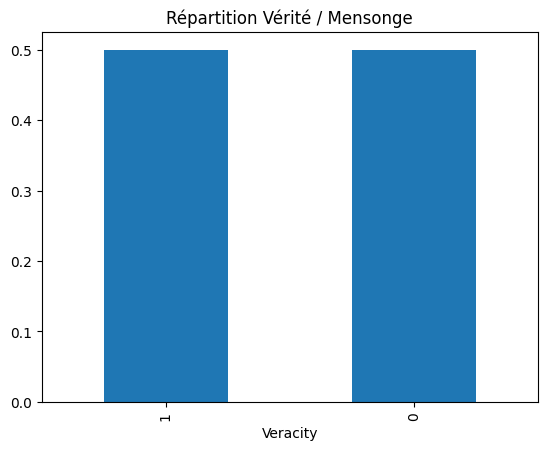

In [ ]:
df_codebook['Veracity'].value_counts(normalize=True).plot(kind='bar', title="Répartition Vérité / Mensonge")


## Étape 5 : Séparation des données

On prépare l'entraînement / test :

In [ ]:
import numpy as np
from sklearn.model_selection import StratifiedKFold # Ajout de l'import
from datasets import Dataset # Assurez-vous que Dataset est importé si nécessaire

from sklearn.model_selection import train_test_split

# Convert lists to numpy arrays to enable indexing with arrays
X_texts = np.array(X_texts)
y_labels = np.array(y_labels)

# 1. Séparation TEST vs TRAIN+VAL (20% pour test)
X_temp, X_test, y_temp, y_test = train_test_split(X_texts, y_labels, test_size=0.2, random_state=42, stratify=y_labels)

# 2. Ensuite, validation croisée sur X_temp et y_temp (donc 80% du total)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
for fold, (train_idx, val_idx) in enumerate(skf.split(X_temp, y_temp)):
    print(f"Fold {fold}: {len(train_idx)} train, {len(val_idx)} val")
    X_train, X_val = X_temp[train_idx], X_temp[val_idx]
    y_train, y_val = y_temp[train_idx], y_temp[val_idx]

    # HuggingFace datasets
    train_dataset = Dataset.from_dict({"text": X_train, "label": y_train})
    val_dataset = Dataset.from_dict({"text": X_val, "label": y_val})

# Conversion du jeu de test final en Dataset HuggingFace
    test_dataset = Dataset.from_dict({
    "text": X_test,
    "label": y_test
})



    # tokenizer, dataset preparation, training...


Fold 0: 204 train, 52 val
Fold 1: 205 train, 51 val
Fold 2: 205 train, 51 val
Fold 3: 205 train, 51 val
Fold 4: 205 train, 51 val


## Étape 6 (BERT) : Prétraitement et vectorisation avec BERT

On utilise le modèle bert-base-uncased (en anglais, adapté à MU3D) avec transformers :


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


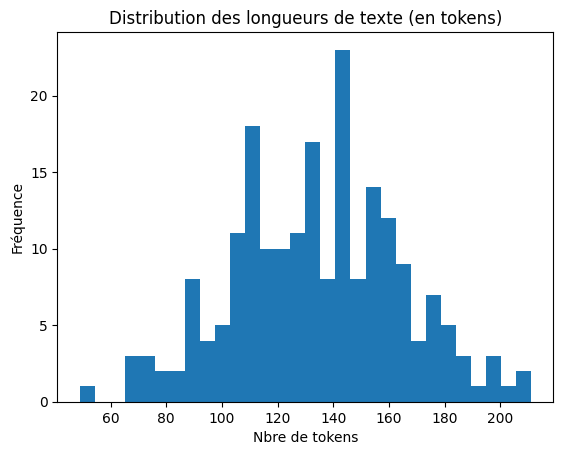

In [ ]:

from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
lengths = [len(tokenizer.tokenize(t)) for t in X_train]
import matplotlib.pyplot as plt
plt.hist(lengths, bins=30)
plt.title("Distribution des longueurs de texte (en tokens)")
plt.xlabel("Nbre de tokens")
plt.ylabel("Fréquence")
plt.show()


Ce que montre le graphique :

La majorité des textes ont une longueur entre 100 et 170 tokens.

Quelques textes dépassent 180-200 tokens.

Très peu sont en dessous de 80 ou au-dessus de 200.

In [ ]:
def tokenize_function(example):
    return tokenizer(
        example["text"],
        padding="max_length",
        truncation=True,
        max_length=128
    )

train_dataset = train_dataset.map(tokenize_function, batched=True)
val_dataset = val_dataset.map(tokenize_function, batched=True)

train_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])
val_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])

test_dataset = test_dataset.map(tokenize_function, batched=True)
test_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])




Map:   0%|          | 0/205 [00:00<?, ? examples/s]

Map:   0%|          | 0/51 [00:00<?, ? examples/s]

Map:   0%|          | 0/64 [00:00<?, ? examples/s]

In [ ]:
from transformers import AutoModelForSequenceClassification
model = AutoModelForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
from transformers import TrainingArguments, Trainer
from transformers import EarlyStoppingCallback

import numpy as np
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=1)

    acc = accuracy_score(labels, preds)
    precision, recall, f1, _ = precision_recall_fscore_support(
        labels, preds, average="binary", pos_label=1
    )

    return {
        "accuracy": acc,
        "precision": precision,
        "recall": recall,
        "f1": f1
    }




In [ ]:
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer
import numpy as np

learning_rates = [2e-5, 3e-5, 5e-5]
epochs_list    = [3,5,8]       # nombre max d'epochs
batch_sizes    = [8, 16]

patience = 2                     # early stopping patience
MAX_LEN = 256                    # utilisé dans ta fonction tokenize_function
best_f1_global = 0.0
best_config = None
best_model_dir = "best_model_global"

for lr in learning_rates:
    for max_epochs in epochs_list:
        for bs in batch_sizes:
            print(f"\n=== Test lr={lr}, max_epochs={max_epochs}, batch_size={bs} ===")

            training_args = TrainingArguments(
                output_dir=f"output_lr{lr}_e{max_epochs}_bs{bs}",
                learning_rate=lr,
                per_device_train_batch_size=bs,
                num_train_epochs=1,     # on gère les epochs à la main
                weight_decay=0.01,
                logging_steps=50,
                seed=42
            )

            model = AutoModelForSequenceClassification.from_pretrained(
                "bert-base-uncased", num_labels=2
            )

            trainer = Trainer(
                model=model,
                args=training_args,
                train_dataset=train_dataset,
                eval_dataset=val_dataset,
                compute_metrics=compute_metrics,
                tokenizer=tokenizer
            )

            best_f1_config = 0.0
            wait = 0
            best_model_dir_config = f"best_model_lr{lr}_e{max_epochs}_bs{bs}"

            for epoch in range(max_epochs):
                print(f"\n--- Epoch {epoch+1}/{max_epochs} ---")
                trainer.train()   # 1 epoch

                eval_results = trainer.evaluate()
                current_f1 = eval_results["eval_f1"]
                print(f"F1 val = {current_f1:.3f}")

                if current_f1 > best_f1_config:
                    best_f1_config = current_f1
                    wait = 0
                    trainer.save_model(best_model_dir_config)
                    tokenizer.save_pretrained(best_model_dir_config)
                    print("✔ Nouveau meilleur modèle pour cette config sauvegardé")
                else:
                    wait += 1
                    print(f"Aucune amélioration, patience = {wait}/{patience}")
                    if wait >= patience:
                        print(f"⛔ Early stopping pour lr={lr}, max_epochs={max_epochs}, bs={bs}")
                        break

            print(f"\nMeilleure F1 pour lr={lr}, max_epochs={max_epochs}, bs={bs} = {best_f1_config:.3f}")

            if best_f1_config > best_f1_global:
                best_f1_global = best_f1_config
                best_config = (lr, max_epochs, bs)
                # tu peux recopier les fichiers du best_model_dir_config vers best_model_dir si tu veux
                print("🌟 Ce modèle devient le meilleur global pour l’instant")

print("\n==============================")
print("Meilleure config globale :", best_config, "avec F1 =", best_f1_global)
print("Modèle sauvegardé dans :", best_model_dir)



=== Test lr=2e-05, max_epochs=3, batch_size=8 ===


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-901095572.py:33: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(



--- Epoch 1/3 ---


Step,Training Loss


F1 val = 0.658
✔ Nouveau meilleur modèle pour cette config sauvegardé

--- Epoch 2/3 ---


Step,Training Loss


F1 val = 0.449
Aucune amélioration, patience = 1/2

--- Epoch 3/3 ---


Step,Training Loss


F1 val = 0.548
Aucune amélioration, patience = 2/2
⛔ Early stopping pour lr=2e-05, max_epochs=3, bs=8

Meilleure F1 pour lr=2e-05, max_epochs=3, bs=8 = 0.658
🌟 Ce modèle devient le meilleur global pour l’instant

=== Test lr=2e-05, max_epochs=3, batch_size=16 ===


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-901095572.py:33: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(



--- Epoch 1/3 ---


Step,Training Loss


F1 val = 0.596
✔ Nouveau meilleur modèle pour cette config sauvegardé

--- Epoch 2/3 ---


Step,Training Loss


F1 val = 0.561
Aucune amélioration, patience = 1/2

--- Epoch 3/3 ---


Step,Training Loss


F1 val = 0.667
✔ Nouveau meilleur modèle pour cette config sauvegardé

Meilleure F1 pour lr=2e-05, max_epochs=3, bs=16 = 0.667
🌟 Ce modèle devient le meilleur global pour l’instant

=== Test lr=2e-05, max_epochs=5, batch_size=8 ===


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-901095572.py:33: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(



--- Epoch 1/5 ---


Step,Training Loss


F1 val = 0.696
✔ Nouveau meilleur modèle pour cette config sauvegardé

--- Epoch 2/5 ---


Step,Training Loss


F1 val = 0.676
Aucune amélioration, patience = 1/2

--- Epoch 3/5 ---


Step,Training Loss


F1 val = 0.688
Aucune amélioration, patience = 2/2
⛔ Early stopping pour lr=2e-05, max_epochs=5, bs=8

Meilleure F1 pour lr=2e-05, max_epochs=5, bs=8 = 0.696
🌟 Ce modèle devient le meilleur global pour l’instant

=== Test lr=2e-05, max_epochs=5, batch_size=16 ===


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-901095572.py:33: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(



--- Epoch 1/5 ---


Step,Training Loss


F1 val = 0.596
✔ Nouveau meilleur modèle pour cette config sauvegardé

--- Epoch 2/5 ---


Step,Training Loss


F1 val = 0.561
Aucune amélioration, patience = 1/2

--- Epoch 3/5 ---


Step,Training Loss


F1 val = 0.667
✔ Nouveau meilleur modèle pour cette config sauvegardé

--- Epoch 4/5 ---


Step,Training Loss


F1 val = 0.577
Aucune amélioration, patience = 1/2

--- Epoch 5/5 ---


Step,Training Loss


F1 val = 0.593
Aucune amélioration, patience = 2/2
⛔ Early stopping pour lr=2e-05, max_epochs=5, bs=16

Meilleure F1 pour lr=2e-05, max_epochs=5, bs=16 = 0.667

=== Test lr=2e-05, max_epochs=8, batch_size=8 ===


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-901095572.py:33: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(



--- Epoch 1/8 ---


Step,Training Loss


F1 val = 0.667
✔ Nouveau meilleur modèle pour cette config sauvegardé

--- Epoch 2/8 ---


Step,Training Loss


F1 val = 0.615
Aucune amélioration, patience = 1/2

--- Epoch 3/8 ---


Step,Training Loss


F1 val = 0.538
Aucune amélioration, patience = 2/2
⛔ Early stopping pour lr=2e-05, max_epochs=8, bs=8

Meilleure F1 pour lr=2e-05, max_epochs=8, bs=8 = 0.667

=== Test lr=2e-05, max_epochs=8, batch_size=16 ===


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-901095572.py:33: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(



--- Epoch 1/8 ---


Step,Training Loss


F1 val = 0.596
✔ Nouveau meilleur modèle pour cette config sauvegardé

--- Epoch 2/8 ---


Step,Training Loss


F1 val = 0.561
Aucune amélioration, patience = 1/2

--- Epoch 3/8 ---


Step,Training Loss


F1 val = 0.667
✔ Nouveau meilleur modèle pour cette config sauvegardé

--- Epoch 4/8 ---


Step,Training Loss


F1 val = 0.577
Aucune amélioration, patience = 1/2

--- Epoch 5/8 ---


Step,Training Loss


F1 val = 0.593
Aucune amélioration, patience = 2/2
⛔ Early stopping pour lr=2e-05, max_epochs=8, bs=16

Meilleure F1 pour lr=2e-05, max_epochs=8, bs=16 = 0.667

=== Test lr=3e-05, max_epochs=3, batch_size=8 ===


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-901095572.py:33: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(



--- Epoch 1/3 ---


Step,Training Loss


F1 val = 0.490
✔ Nouveau meilleur modèle pour cette config sauvegardé

--- Epoch 2/3 ---


Step,Training Loss


F1 val = 0.533
✔ Nouveau meilleur modèle pour cette config sauvegardé

--- Epoch 3/3 ---


Step,Training Loss


F1 val = 0.537
✔ Nouveau meilleur modèle pour cette config sauvegardé

Meilleure F1 pour lr=3e-05, max_epochs=3, bs=8 = 0.537

=== Test lr=3e-05, max_epochs=3, batch_size=16 ===


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-901095572.py:33: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(



--- Epoch 1/3 ---


Step,Training Loss


F1 val = 0.450
✔ Nouveau meilleur modèle pour cette config sauvegardé

--- Epoch 2/3 ---


Step,Training Loss


F1 val = 0.687
✔ Nouveau meilleur modèle pour cette config sauvegardé

--- Epoch 3/3 ---


Step,Training Loss


F1 val = 0.635
Aucune amélioration, patience = 1/2

Meilleure F1 pour lr=3e-05, max_epochs=3, bs=16 = 0.687

=== Test lr=3e-05, max_epochs=5, batch_size=8 ===


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-901095572.py:33: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(



--- Epoch 1/5 ---


Step,Training Loss


F1 val = 0.658
✔ Nouveau meilleur modèle pour cette config sauvegardé

--- Epoch 2/5 ---


Step,Training Loss


F1 val = 0.706
✔ Nouveau meilleur modèle pour cette config sauvegardé

--- Epoch 3/5 ---


Step,Training Loss


F1 val = 0.630
Aucune amélioration, patience = 1/2

--- Epoch 4/5 ---


Step,Training Loss


F1 val = 0.655
Aucune amélioration, patience = 2/2
⛔ Early stopping pour lr=3e-05, max_epochs=5, bs=8

Meilleure F1 pour lr=3e-05, max_epochs=5, bs=8 = 0.706
🌟 Ce modèle devient le meilleur global pour l’instant

=== Test lr=3e-05, max_epochs=5, batch_size=16 ===


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-901095572.py:33: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(



--- Epoch 1/5 ---


Step,Training Loss


F1 val = 0.658
✔ Nouveau meilleur modèle pour cette config sauvegardé

--- Epoch 2/5 ---


Step,Training Loss


F1 val = 0.627
Aucune amélioration, patience = 1/2

--- Epoch 3/5 ---


Step,Training Loss


F1 val = 0.667
✔ Nouveau meilleur modèle pour cette config sauvegardé

--- Epoch 4/5 ---


Step,Training Loss


F1 val = 0.635
Aucune amélioration, patience = 1/2

--- Epoch 5/5 ---


Step,Training Loss


F1 val = 0.678
✔ Nouveau meilleur modèle pour cette config sauvegardé

Meilleure F1 pour lr=3e-05, max_epochs=5, bs=16 = 0.678

=== Test lr=3e-05, max_epochs=8, batch_size=8 ===


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-901095572.py:33: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(



--- Epoch 1/8 ---


Step,Training Loss


F1 val = 0.490
✔ Nouveau meilleur modèle pour cette config sauvegardé

--- Epoch 2/8 ---


Step,Training Loss


F1 val = 0.533
✔ Nouveau meilleur modèle pour cette config sauvegardé

--- Epoch 3/8 ---


Step,Training Loss


F1 val = 0.537
✔ Nouveau meilleur modèle pour cette config sauvegardé

--- Epoch 4/8 ---


Step,Training Loss


F1 val = 0.450
Aucune amélioration, patience = 1/2

--- Epoch 5/8 ---


Step,Training Loss


F1 val = 0.619
✔ Nouveau meilleur modèle pour cette config sauvegardé

--- Epoch 6/8 ---


Step,Training Loss


F1 val = 0.513
Aucune amélioration, patience = 1/2

--- Epoch 7/8 ---


Step,Training Loss


F1 val = 0.526
Aucune amélioration, patience = 2/2
⛔ Early stopping pour lr=3e-05, max_epochs=8, bs=8

Meilleure F1 pour lr=3e-05, max_epochs=8, bs=8 = 0.619

=== Test lr=3e-05, max_epochs=8, batch_size=16 ===


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-901095572.py:33: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(



--- Epoch 1/8 ---


Step,Training Loss


F1 val = 0.676
✔ Nouveau meilleur modèle pour cette config sauvegardé

--- Epoch 2/8 ---


Step,Training Loss


F1 val = 0.549
Aucune amélioration, patience = 1/2

--- Epoch 3/8 ---


Step,Training Loss


F1 val = 0.590
Aucune amélioration, patience = 2/2
⛔ Early stopping pour lr=3e-05, max_epochs=8, bs=16

Meilleure F1 pour lr=3e-05, max_epochs=8, bs=16 = 0.676

=== Test lr=5e-05, max_epochs=3, batch_size=8 ===


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-901095572.py:33: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(



--- Epoch 1/3 ---


Step,Training Loss


F1 val = 0.615
✔ Nouveau meilleur modèle pour cette config sauvegardé

--- Epoch 2/3 ---


Step,Training Loss


F1 val = 0.582
Aucune amélioration, patience = 1/2

--- Epoch 3/3 ---


Step,Training Loss


F1 val = 0.618
✔ Nouveau meilleur modèle pour cette config sauvegardé

Meilleure F1 pour lr=5e-05, max_epochs=3, bs=8 = 0.618

=== Test lr=5e-05, max_epochs=3, batch_size=16 ===


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-901095572.py:33: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(



--- Epoch 1/3 ---


Step,Training Loss


F1 val = 0.303
✔ Nouveau meilleur modèle pour cette config sauvegardé

--- Epoch 2/3 ---


Step,Training Loss


F1 val = 0.643
✔ Nouveau meilleur modèle pour cette config sauvegardé

--- Epoch 3/3 ---


Step,Training Loss


F1 val = 0.648
✔ Nouveau meilleur modèle pour cette config sauvegardé

Meilleure F1 pour lr=5e-05, max_epochs=3, bs=16 = 0.648

=== Test lr=5e-05, max_epochs=5, batch_size=8 ===


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-901095572.py:33: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(



--- Epoch 1/5 ---


Step,Training Loss


F1 val = 0.615
✔ Nouveau meilleur modèle pour cette config sauvegardé

--- Epoch 2/5 ---


Step,Training Loss


F1 val = 0.582
Aucune amélioration, patience = 1/2

--- Epoch 3/5 ---


Step,Training Loss


F1 val = 0.618
✔ Nouveau meilleur modèle pour cette config sauvegardé

--- Epoch 4/5 ---


Step,Training Loss


F1 val = 0.549
Aucune amélioration, patience = 1/2

--- Epoch 5/5 ---


Step,Training Loss


F1 val = 0.553
Aucune amélioration, patience = 2/2
⛔ Early stopping pour lr=5e-05, max_epochs=5, bs=8

Meilleure F1 pour lr=5e-05, max_epochs=5, bs=8 = 0.618

=== Test lr=5e-05, max_epochs=5, batch_size=16 ===


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-901095572.py:33: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(



--- Epoch 1/5 ---


Step,Training Loss


F1 val = 0.350
✔ Nouveau meilleur modèle pour cette config sauvegardé

--- Epoch 2/5 ---


Step,Training Loss


F1 val = 0.611
✔ Nouveau meilleur modèle pour cette config sauvegardé

--- Epoch 3/5 ---


Step,Training Loss


F1 val = 0.593
Aucune amélioration, patience = 1/2

--- Epoch 4/5 ---


Step,Training Loss


F1 val = 0.655
✔ Nouveau meilleur modèle pour cette config sauvegardé

--- Epoch 5/5 ---


Step,Training Loss


F1 val = 0.549
Aucune amélioration, patience = 1/2

Meilleure F1 pour lr=5e-05, max_epochs=5, bs=16 = 0.655

=== Test lr=5e-05, max_epochs=8, batch_size=8 ===


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-901095572.py:33: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(



--- Epoch 1/8 ---


Step,Training Loss


F1 val = 0.350
✔ Nouveau meilleur modèle pour cette config sauvegardé

--- Epoch 2/8 ---


Step,Training Loss


F1 val = 0.250
Aucune amélioration, patience = 1/2

--- Epoch 3/8 ---


Step,Training Loss


F1 val = 0.368
✔ Nouveau meilleur modèle pour cette config sauvegardé

--- Epoch 4/8 ---


Step,Training Loss


F1 val = 0.565
✔ Nouveau meilleur modèle pour cette config sauvegardé

--- Epoch 5/8 ---


Step,Training Loss


F1 val = 0.558
Aucune amélioration, patience = 1/2

--- Epoch 6/8 ---


Step,Training Loss


F1 val = 0.571
✔ Nouveau meilleur modèle pour cette config sauvegardé

--- Epoch 7/8 ---


Step,Training Loss


F1 val = 0.421
Aucune amélioration, patience = 1/2

--- Epoch 8/8 ---


Step,Training Loss


F1 val = 0.531
Aucune amélioration, patience = 2/2
⛔ Early stopping pour lr=5e-05, max_epochs=8, bs=8

Meilleure F1 pour lr=5e-05, max_epochs=8, bs=8 = 0.571

=== Test lr=5e-05, max_epochs=8, batch_size=16 ===


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-901095572.py:33: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(



--- Epoch 1/8 ---


Step,Training Loss


F1 val = 0.542
✔ Nouveau meilleur modèle pour cette config sauvegardé

--- Epoch 2/8 ---


Step,Training Loss


F1 val = 0.667
✔ Nouveau meilleur modèle pour cette config sauvegardé

--- Epoch 3/8 ---


Step,Training Loss


F1 val = 0.632
Aucune amélioration, patience = 1/2

--- Epoch 4/8 ---


Step,Training Loss


F1 val = 0.640
Aucune amélioration, patience = 2/2
⛔ Early stopping pour lr=5e-05, max_epochs=8, bs=16

Meilleure F1 pour lr=5e-05, max_epochs=8, bs=16 = 0.667

Meilleure config globale : (3e-05, 5, 8) avec F1 = 0.7058823529411765
Modèle sauvegardé dans : best_model_global


## Recharger le meilleur model global et l'evaluer sur du test

In [ ]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer, Trainer

best_model_dir = "best_model_lr3e-05_e5_bs8"


best_model = AutoModelForSequenceClassification.from_pretrained(best_model_dir)
best_tokenizer = AutoTokenizer.from_pretrained(best_model_dir)

test_trainer = Trainer(
    model=best_model,
    args=training_args,          # tu peux réutiliser les args ou en recréer un simple
    eval_dataset=test_dataset,
    tokenizer=best_tokenizer,
    compute_metrics=compute_metrics
)

test_metrics = test_trainer.evaluate()
print(test_metrics)


/tmp/ipython-input-989611653.py:9: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  test_trainer = Trainer(


{'eval_loss': 0.6876510977745056, 'eval_model_preparation_time': 0.003, 'eval_accuracy': 0.59375, 'eval_precision': 0.5555555555555556, 'eval_recall': 0.9375, 'eval_f1': 0.6976744186046512, 'eval_runtime': 0.176, 'eval_samples_per_second': 363.682, 'eval_steps_per_second': 45.46}


Après optimisation des hyperparamètres (lr, batch size, nombre d’époques) et mise en place d’un early stopping manuel, le meilleur modèle BERT atteint un F1-score de 0,71 sur le jeu de validation.

Sur le jeu de test, totalement séparé, le modèle obtient une accuracy de 59,4 %, une précision de 55,6 %, un rappel de 93,8 % et un F1-score de 0,70.

Ces résultats montrent que le modèle est particulièrement efficace pour détecter les mensonges (très haut rappel) au prix d’un certain nombre de faux positifs (vérités classées comme mensonges). La performance reste modérée en accuracy, ce qui est cohérent avec la difficulté intrinsèque de la détection de mensonge à partir du texte seul et avec la petite taille du dataset MU3D.

In [ ]:
import numpy as np

# Prédictions du modèle sur le test
predictions = test_trainer.predict(test_dataset)

# logits → probas softmax → p(mensonge)
logits = predictions.predictions
probas = np.exp(logits) / np.exp(logits).sum(axis=1, keepdims=True)

# classe prédite
y_pred = np.argmax(logits, axis=1)

# vraies étiquettes
y_true = predictions.label_ids


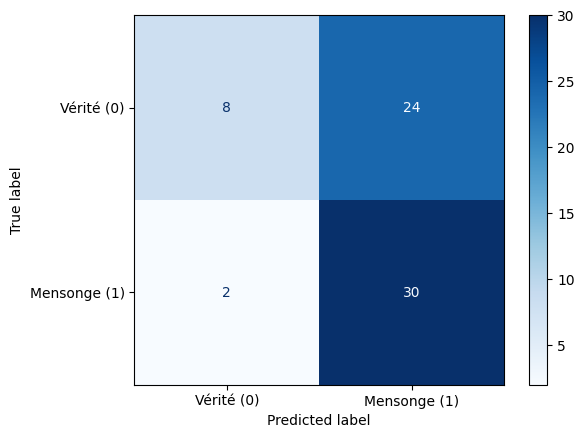

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Vérité (0)", "Mensonge (1)"])
disp.plot(cmap="Blues")


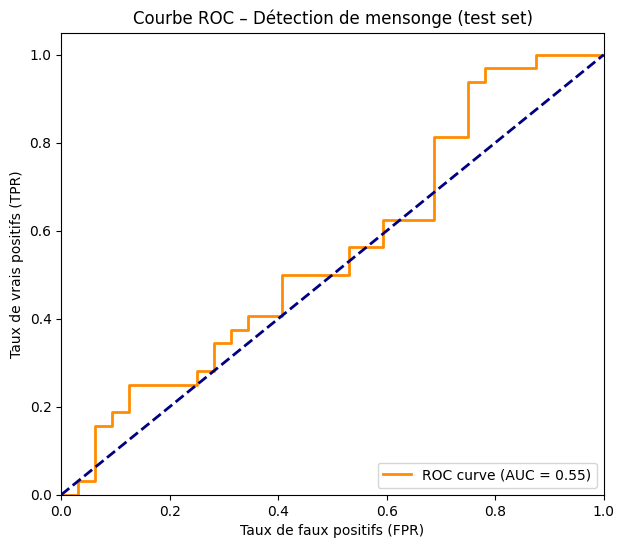

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Probabilité prédites pour la classe 1 (mensonge)
y_score = probas[:, 1]

fpr, tpr, thresholds = roc_curve(y_true, y_score)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(7, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label="ROC curve (AUC = %0.2f)" % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("Taux de faux positifs (FPR)")
plt.ylabel("Taux de vrais positifs (TPR)")
plt.title("Courbe ROC – Détection de mensonge (test set)")
plt.legend(loc="lower right")
plt.show()


Un AUC (Area Under Curve) de :

0.5 → modèle aléatoire

0.55 → modèle légèrement meilleur que le hasard

0.60–0.70 → modèle correct

> 0.80 → très bon modèle

> 0.90 → excellent

MU3D = environ 320 vidéos, mais les transcriptions réelles exploitables sont :

✔ courtes
✔ peu variées
✔ souvent semblables d’un mensonge à l’autre

BERT a alors peu de matière linguistique pour apprendre ce qui distingue vérité/mensonge.

Donc un AUC faible est normal dans ce contexte scientifique.

# On passe au multimodal

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import os
mu3d_path = "/content/drive/Othercomputers/Mon ordinateur portable/Downloads/MU3D-Package/MU3D-Package"
print("Contenu du dossier MU3D :", os.listdir(mu3d_path))


Contenu du dossier MU3D : ['MU3D Codebook.xlsx', 'Unzipping the data.txt', 'Useage Agreement.docx', 'Videos.zip', '~$MU3D Codebook.xlsx', 'Videos', 'Audio']


In [ ]:
videos_zip_path = os.path.join(mu3d_path, "Videos.zip")


In [ ]:
videos_dir = os.path.join(mu3d_path, "Videos")

Installe 7zip

In [ ]:
!apt-get install -y p7zip-full


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
p7zip-full is already the newest version (16.02+dfsg-8).
0 upgraded, 0 newly installed, 0 to remove and 41 not upgraded.


# On dezippe la pile de vidéos

In [ ]:
password = "yj566238MiamiU"

!7z x "{videos_zip_path}" -o"{videos_dir}" -p{password}



7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,8 CPUs Intel(R) Xeon(R) CPU @ 2.00GHz (50653),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan /content/drive/Othercomputers/M . oads/MU3D-Package/MU3D-Package/                                                                           1 file, 1635396955 bytes (1560 MiB)

Extracting archive: /content/drive/Othercomputers/Mon ordinateur portable/Downloads/MU3D-Package/MU3D-Package/Videos.zip
--
Path = /content/drive/Othercomputers/Mon ordinateur portable/Downloads/MU3D-Package/MU3D-Package/Videos.zip
Type = zip
Physical Size = 1635396955

  0%    
Would you like to replace the existing file:
  Path:     /content/drive/Othercomputers/Mon ordinateur portable/Downloads/MU3D-Package/MU3D-Packa

In [ ]:
import os
os.listdir(videos_dir)[:10]


['Videos']

In [ ]:
inner = os.path.join(videos_dir, "Videos")
os.listdir(inner)[:10]


In [ ]:
len(os.listdir(inner))


321

## table qui mappe VideoID → chemin vidéo

Parfait pour la suite multimodale.

In [ ]:
video_paths = {
    f.split('.')[0]: os.path.join(inner, f)
    for f in os.listdir(inner)
    if f.endswith(".wmv")
}

list(video_paths.items())[:5]


[('BF001_1PT',
  '/content/drive/Othercomputers/Mon ordinateur portable/Downloads/MU3D-Package/MU3D-Package/Videos/Videos/BF001_1PT.wmv'),
 ('BF028_4PL',
  '/content/drive/Othercomputers/Mon ordinateur portable/Downloads/MU3D-Package/MU3D-Package/Videos/Videos/BF028_4PL.wmv'),
 ('BF033_1PT',
  '/content/drive/Othercomputers/Mon ordinateur portable/Downloads/MU3D-Package/MU3D-Package/Videos/Videos/BF033_1PT.wmv'),
 ('BF033_2NL',
  '/content/drive/Othercomputers/Mon ordinateur portable/Downloads/MU3D-Package/MU3D-Package/Videos/Videos/BF033_2NL.wmv'),
 ('BF033_3NT',
  '/content/drive/Othercomputers/Mon ordinateur portable/Downloads/MU3D-Package/MU3D-Package/Videos/Videos/BF033_3NT.wmv')]

In [ ]:
import pandas as pd
import os

codebook_path = os.path.join(mu3d_path, "MU3D Codebook.xlsx")

df_vid = pd.read_excel(codebook_path, sheet_name="Video-Level Data")

# On enlève éventuellement les lignes sans transcription (si tu veux un pipeline texte+audio+vidéo)
df_vid = df_vid.dropna(subset=["Transcription"]).reset_index(drop=True)

# Veracity = 1 => truth, 0 => lie
# On choisit label = 1 => mensonge, 0 => vérité
df_vid["label"] = df_vid["Veracity"].apply(lambda v: 1 - v)

df_vid[["VideoID", "Veracity", "label"]].head()


,VideoID,Veracity,label
0,BF001_1PT,1,0
1,BF001_2NL,0,1
2,BF001_3NT,1,0
3,BF001_4PL,0,1
4,BF002_1PT,1,0


## Associer chaque VideoID à un chemin vidéo

In [ ]:
# Dictionnaire {nom_sans_extension: chemin_complet}
video_paths = {}
for f in os.listdir(inner):
    if f.lower().endswith(".wmv"):
        stem = os.path.splitext(f)[0]  # "BF001_1PT"
        video_paths[stem] = os.path.join(inner, f)

len(video_paths), list(video_paths.items())[:5]


(320,
 [('BF001_1PT',
   '/content/drive/Othercomputers/Mon ordinateur portable/Downloads/MU3D-Package/MU3D-Package/Videos/Videos/BF001_1PT.wmv'),
  ('BF028_4PL',
   '/content/drive/Othercomputers/Mon ordinateur portable/Downloads/MU3D-Package/MU3D-Package/Videos/Videos/BF028_4PL.wmv'),
  ('BF033_1PT',
   '/content/drive/Othercomputers/Mon ordinateur portable/Downloads/MU3D-Package/MU3D-Package/Videos/Videos/BF033_1PT.wmv'),
  ('BF033_2NL',
   '/content/drive/Othercomputers/Mon ordinateur portable/Downloads/MU3D-Package/MU3D-Package/Videos/Videos/BF033_2NL.wmv'),
  ('BF033_3NT',
   '/content/drive/Othercomputers/Mon ordinateur portable/Downloads/MU3D-Package/MU3D-Package/Videos/Videos/BF033_3NT.wmv')])

In [ ]:
df_vid["video_path"] = df_vid["VideoID"].map(video_paths)

missing_videos = df_vid[df_vid["video_path"].isna()]
print("Vidéos non trouvées pour ces lignes :", len(missing_videos))
missing_videos[["VideoID"]].head()


Vidéos non trouvées pour ces lignes : 4


,VideoID
240,WM001_1PT
274,WM013_3NT
294,WM019_3NT
295,WM019_4PL


## Extraire l’audio de chaque vidéo (en .wav)

On crée un dossier Audio/ à côté de Videos/, puis on utilise ffmpeg pour chaque vidéo.

In [ ]:
from pathlib import Path
import subprocess

audio_dir = Path(os.path.join(mu3d_path, "Audio"))
audio_dir.mkdir(exist_ok=True)

for path in df_vid["video_path"].dropna():
    path = Path(path)
    out_wav = audio_dir / f"{path.stem}.wav"
    if not out_wav.exists():
        print("Extraction audio pour", path.name)
        cmd = [
            "ffmpeg",
            "-i", str(path),    # fichier vidéo en entrée
            "-vn",              # no video
            "-ac", "1",         # mono
            "-ar", "16000",     # 16 kHz, standard pour l'IA audio
            "-y", str(out_wav)  # overwrite
        ]
        subprocess.run(cmd, stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)

print("Nb de fichiers audio créés :", len(list(audio_dir.glob("*.wav"))))


Nb de fichiers audio créés : 316


## Associer chaque VideoID à un chemin audio

On construit un dict comme pour la vidéo :

In [ ]:
audio_paths = {p.stem: str(p) for p in audio_dir.glob("*.wav")}

df_vid["audio_path"] = df_vid["VideoID"].map(audio_paths)

missing_audio = df_vid[df_vid["audio_path"].isna()]
print("Audios non trouvés :", len(missing_audio))
missing_audio[["VideoID"]].head()


Audios non trouvés : 4


,VideoID
240,WM001_1PT
274,WM013_3NT
294,WM019_3NT
295,WM019_4PL


In [ ]:
df_vid[["VideoID", "label", "Transcription", "video_path", "audio_path"]].sample(10)


,VideoID,label,Transcription,video_path,audio_path
266,WM009_3NT,0,A man I really dislike. He was the new Dean of...,/content/drive/Othercomputers/Mon ordinateur p...,/content/drive/Othercomputers/Mon ordinateur p...
121,BM014_2NL,1,"Someone I don’t like um, I’d have to say my ne...",/content/drive/Othercomputers/Mon ordinateur p...,/content/drive/Othercomputers/Mon ordinateur p...
53,BF022_2NL,1,"Uh, this person, she’s just has a nasty attitu...",/content/drive/Othercomputers/Mon ordinateur p...,/content/drive/Othercomputers/Mon ordinateur p...
164,WF003_1PT,0,We met in our freshmen dorm um she has brown h...,/content/drive/Othercomputers/Mon ordinateur p...,/content/drive/Othercomputers/Mon ordinateur p...
48,BF020_1PT,0,I really like this person that I met at Miami ...,/content/drive/Othercomputers/Mon ordinateur p...,/content/drive/Othercomputers/Mon ordinateur p...
50,BF020_3NT,0,There's this guy and I can't stand him. Um. I ...,/content/drive/Othercomputers/Mon ordinateur p...,/content/drive/Othercomputers/Mon ordinateur p...
36,BF016_1PT,0,I really like um my friend because he’s really...,/content/drive/Othercomputers/Mon ordinateur p...,/content/drive/Othercomputers/Mon ordinateur p...
81,BM003_2NL,1,We met in kindergarten and he pretended to be ...,/content/drive/Othercomputers/Mon ordinateur p...,/content/drive/Othercomputers/Mon ordinateur p...
91,BM005_4PL,1,"He’s a pretty good guy. He um, he was really h...",/content/drive/Othercomputers/Mon ordinateur p...,/content/drive/Othercomputers/Mon ordinateur p...
299,WM020_4PL,1,"Um, I met him about a year ago, um, and ever s...",/content/drive/Othercomputers/Mon ordinateur p...,/content/drive/Othercomputers/Mon ordinateur p...


In [ ]:
df_vid[["VideoID", "label", "video_path", "audio_path"]].head(20)


,VideoID,label,video_path,audio_path
0,BF001_1PT,0,/content/drive/Othercomputers/Mon ordinateur p...,/content/drive/Othercomputers/Mon ordinateur p...
1,BF001_2NL,1,/content/drive/Othercomputers/Mon ordinateur p...,/content/drive/Othercomputers/Mon ordinateur p...
2,BF001_3NT,0,/content/drive/Othercomputers/Mon ordinateur p...,/content/drive/Othercomputers/Mon ordinateur p...
3,BF001_4PL,1,/content/drive/Othercomputers/Mon ordinateur p...,/content/drive/Othercomputers/Mon ordinateur p...
4,BF002_1PT,0,/content/drive/Othercomputers/Mon ordinateur p...,/content/drive/Othercomputers/Mon ordinateur p...
5,BF002_2NL,1,/content/drive/Othercomputers/Mon ordinateur p...,/content/drive/Othercomputers/Mon ordinateur p...
6,BF002_3NT,0,/content/drive/Othercomputers/Mon ordinateur p...,/content/drive/Othercomputers/Mon ordinateur p...
7,BF002_4PL,1,/content/drive/Othercomputers/Mon ordinateur p...,/content/drive/Othercomputers/Mon ordinateur p...
8,BF003_1PT,0,/content/drive/Othercomputers/Mon ordinateur p...,/content/drive/Othercomputers/Mon ordinateur p...
9,BF003_2NL,1,/content/drive/Othercomputers/Mon ordinateur p...,/content/drive/Othercomputers/Mon ordinateur p...




##Extraction des features audio (MFCC)

##Construction d’un Dataset PyTorch multimodal

##Définition d’un modèle texte + audio (BERT + MLP audio, concat)



1️⃣ Extraction des features audio (MFCC via librosa)

##  a) Installer et importer

In [ ]:


import librosa
import numpy as np
import os
from tqdm import tqdm


## b) Fonction pour extraire un vecteur MFCC fixe par audio

On va faire simple :

13 MFCC

on fait la moyenne et l’écart-type sur le temps
→ vecteur final de taille 26 par fichier audio

In [ ]:
def extract_mfcc_vector(audio_path, sr=16000, n_mfcc=13):
    """
    Retourne un vecteur de taille 2*n_mfcc : [mean(mfcc), std(mfcc)].
    """
    y, sr = librosa.load(audio_path, sr=sr)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)  # shape: (n_mfcc, T)
    mfcc_mean = mfcc.mean(axis=1)
    mfcc_std = mfcc.std(axis=1)
    return np.concatenate([mfcc_mean, mfcc_std], axis=0)   # shape (2*n_mfcc,)


## c) Boucle sur toutes les lignes de df_vid

On crée un tableau audio_features aligné avec le DataFrame :

In [ ]:
audio_features = []

for idx, row in tqdm(df_vid.iterrows(), total=len(df_vid)):
    path = row["audio_path"]
    if isinstance(path, str) and os.path.exists(path):
        vec = extract_mfcc_vector(path)
    else:
        # Cas rare : audio manquant → vecteur nul
        vec = np.zeros(26, dtype=np.float32)
    audio_features.append(vec)

audio_features = np.stack(audio_features)  # shape: (N, 26)
audio_features.shape


100%|██████████| 320/320 [01:18<00:00,  4.09it/s]


(320, 26)

In [ ]:
df_vid["audio_feat"] = list(audio_features)
df_vid[["VideoID", "label", "audio_path", "audio_feat"]].head()


,VideoID,label,audio_path,audio_feat
0,BF001_1PT,0,/content/drive/Othercomputers/Mon ordinateur p...,"[-372.1495, 74.6463, 4.9678464, 28.15551, -22...."
1,BF001_2NL,1,/content/drive/Othercomputers/Mon ordinateur p...,"[-408.18744, 74.07717, 7.4736915, 30.358297, -..."
2,BF001_3NT,0,/content/drive/Othercomputers/Mon ordinateur p...,"[-392.86328, 75.78993, 5.086667, 27.130283, -1..."
3,BF001_4PL,1,/content/drive/Othercomputers/Mon ordinateur p...,"[-388.0531, 73.19296, 4.764725, 20.287766, -18..."
4,BF002_1PT,0,/content/drive/Othercomputers/Mon ordinateur p...,"[-375.79608, 75.887405, 2.2181153, 23.30234, -..."


## Dataset PyTorch multimodal (Texte + Audio) - GILLES

On va utiliser un tokenizer BERT/DistilBERT pour le texte, et les MFCC comme feature audio.

a) Importer transformers et définir tokenizer

Tu peux repartir sur le même modèle  (bert-base-uncased)

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer

model_name = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

## b) Préparer les arrays numpy

In [ ]:
texts = df_vid["Transcription"].tolist()
labels = df_vid["label"].values.astype(int)
audio_feats = audio_features.astype(np.float32)  # (N, 26)


## c) Définir le Dataset

In [ ]:
class TextAudioDataset(Dataset):
    def __init__(self, texts, audio_feats, labels, tokenizer, max_len=256):
        self.texts = texts
        self.audio_feats = audio_feats
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        audio_vec = self.audio_feats[idx]
        label = self.labels[idx]

        encoding = self.tokenizer(
            text,
            padding="max_length",
            truncation=True,
            max_length=self.max_len,
            return_tensors="pt"
        )

        item = {
            "input_ids": encoding["input_ids"].squeeze(0),
            "attention_mask": encoding["attention_mask"].squeeze(0),
            "audio_feats": torch.tensor(audio_vec, dtype=torch.float32),
            "labels": torch.tensor(label, dtype=torch.long),
        }
        return item


## d) Split train / test

Par exemple 80/20 comme avant :

In [ ]:
from sklearn.model_selection import train_test_split

X_train_text, X_test_text, X_train_audio, X_test_audio, y_train, y_test = train_test_split(
    texts,
    audio_feats,
    labels,
    test_size=0.2,
    random_state=42,
    stratify=labels
)

train_dataset = TextAudioDataset(X_train_text, X_train_audio, y_train, tokenizer)
test_dataset  = TextAudioDataset(X_test_text,  X_test_audio,  y_test,  tokenizer)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader  = DataLoader(test_dataset,  batch_size=8, shuffle=False)


## 3️⃣ Modèle multimodal : DistilBERT + MLP audio + concat

On définit un modèle PyTorch :

encodeur texte : DistilBERT (ou BERT)

encodeur audio : petit MLP sur les 26 MFCC (par ex. 26 → 64)

concat des deux → dense → 2 classes

In [ ]:
import torch.nn as nn
from transformers import AutoModel

class MultiModalTextAudio(nn.Module):
    def __init__(self, model_name="distilbert-base-uncased", audio_dim=26, num_labels=2, freeze_bert=False):
        super().__init__()
        self.text_encoder = AutoModel.from_pretrained(model_name)
        hidden_size = self.text_encoder.config.hidden_size  # 768 pour distilbert-base-uncased

        # MLP audio simple
        self.audio_mlp = nn.Sequential(
            nn.Linear(audio_dim, 64),
            nn.ReLU(),
            nn.Dropout(0.3)
        )

        # Fusion texte(768) + audio(64) = 832
        self.classifier = nn.Sequential(
            nn.Linear(hidden_size + 64, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, num_labels)
        )

        if freeze_bert:
            for param in self.text_encoder.parameters():
                param.requires_grad = False

        self.loss_fn = nn.CrossEntropyLoss()

    def forward(self, input_ids, attention_mask, audio_feats, labels=None):
        # Encodeur texte
        outputs = self.text_encoder(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        # DistilBERT: last_hidden_state[:,0,:] = "pseudo CLS"
        cls_embedding = outputs.last_hidden_state[:, 0, :]  # (B, 768)

        # Encodeur audio
        audio_embedding = self.audio_mlp(audio_feats)        # (B, 64)

        # Fusion
        fused = torch.cat([cls_embedding, audio_embedding], dim=1)  # (B, 832)
        logits = self.classifier(fused)                             # (B, 2)

        loss = None
        if labels is not None:
            loss = self.loss_fn(logits, labels)

        return {"loss": loss, "logits": logits}


## 4️⃣ Esquisse de boucle d’entraînement



In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MultiModalTextAudio(model_name=model_name, audio_dim=26, num_labels=2, freeze_bert=False)
model.to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
num_epochs = 3

for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0
    for batch in train_loader:
        optimizer.zero_grad()
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(
            input_ids=batch["input_ids"],
            attention_mask=batch["attention_mask"],
            audio_feats=batch["audio_feats"],
            labels=batch["labels"]
        )
        loss = outputs["loss"]
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}/{num_epochs} - Loss train: {total_loss/len(train_loader):.4f}")


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Epoch 1/3 - Loss train: 1.5158
Epoch 2/3 - Loss train: 1.3059
Epoch 3/3 - Loss train: 1.2311


In [ ]:
from sklearn.metrics import classification_report

model.eval()
all_preds, all_labels = [], []

with torch.no_grad():
    for batch in test_loader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(
            input_ids=batch["input_ids"],
            attention_mask=batch["attention_mask"],
            audio_feats=batch["audio_feats"]
        )
        logits = outputs["logits"]
        preds = logits.argmax(dim=1).cpu().numpy()
        labels = batch["labels"].cpu().numpy()

        all_preds.extend(preds)
        all_labels.extend(labels)

print(classification_report(all_labels, all_preds, target_names=["Vérité", "Mensonge"]))


              precision    recall  f1-score   support

      Vérité       0.00      0.00      0.00        32
    Mensonge       0.50      1.00      0.67        32

    accuracy                           0.50        64
   macro avg       0.25      0.50      0.33        64
weighted avg       0.25      0.50      0.33        64



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


# Préparation des données (train / val / test)

#Extraction d’embeddings audio Wav2Vec2 (768D)

#Dataset PyTorch multimodal

#Modèle : DistilBERT + Wav2Vec2 (embeddings) + fusion propre

#Entraînement avec early stopping sur F1 (mensonge)

## Pré-requis

On part du df_vid que tu as déjà :

Transcription (texte)

label (0 = vérité, 1 = mensonge)

audio_path (chemin .wav sans NaN)

In [ ]:
df_vid[["VideoID", "label", "Transcription", "audio_path"]].head()
df_vid["label"].value_counts()


,count
label,
0,160
1,160


## 1️⃣ Split train / val / test (stratifié)

On fait un split 70% train, 15% val, 15% test.

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split

texts = df_vid["Transcription"].values
labels = df_vid["label"].values
audio_paths = df_vid["audio_path"].values

# 1) train+val vs test
X_temp_text, X_test_text, y_temp, y_test, X_temp_audio, X_test_audio = train_test_split(
    texts,
    labels,
    audio_paths,
    test_size=0.15,
    random_state=42,
    stratify=labels
)

# 2) train vs val (sur le reste)
X_train_text, X_val_text, y_train, y_val, X_train_audio, X_val_audio = train_test_split(
    X_temp_text,
    y_temp,
    X_temp_audio,
    test_size=0.1765,  # ≈ 0.1765 * 0.85 ≈ 0.15 → 15% total
    random_state=42,
    stratify=y_temp
)

print("Train :", len(X_train_text))
print("Val   :", len(X_val_text))
print("Test  :", len(X_test_text))


Train : 223
Val   : 49
Test  : 48


## 2️⃣ Extraction des embeddings audio Wav2Vec2 (768D)

On va pré-calculer les embeddings audio pour chaque split.
Comme ça le modèle sera plus rapide (on n’appelle pas Wav2Vec2 à chaque batch).

In [ ]:
!pip install soundfile --quiet

import torch
import soundfile as sf
from transformers import Wav2Vec2Processor, Wav2Vec2Model

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device :", device)

audio_model_name = "facebook/wav2vec2-base-960h"
processor = Wav2Vec2Processor.from_pretrained(audio_model_name)
wav2vec = Wav2Vec2Model.from_pretrained(audio_model_name).to(device)
wav2vec.eval()


Device : cuda


preprocessor_config.json:   0%|          | 0.00/159 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/163 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

vocab.json:   0%|          | 0.00/291 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/85.0 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/378M [00:00<?, ?B/s]

Some weights of Wav2Vec2Model were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Wav2Vec2Model(
  (feature_extractor): Wav2Vec2FeatureEncoder(
    (conv_layers): ModuleList(
      (0): Wav2Vec2GroupNormConvLayer(
        (conv): Conv1d(1, 512, kernel_size=(10,), stride=(5,), bias=False)
        (activation): GELUActivation()
        (layer_norm): GroupNorm(512, 512, eps=1e-05, affine=True)
      )
      (1-4): 4 x Wav2Vec2NoLayerNormConvLayer(
        (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,), bias=False)
        (activation): GELUActivation()
      )
      (5-6): 2 x Wav2Vec2NoLayerNormConvLayer(
        (conv): Conv1d(512, 512, kernel_size=(2,), stride=(2,), bias=False)
        (activation): GELUActivation()
      )
    )
  )
  (feature_projection): Wav2Vec2FeatureProjection(
    (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
    (projection): Linear(in_features=512, out_features=768, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): Wav2Vec2Encoder(
    (pos_conv_embed): Wav2Vec2PositionalConvEmbedding(
  

## b) Fonction d’extraction

On prend la moyenne temporelle des sorties cachées → vecteur 768D.

In [ ]:
import numpy as np
from tqdm import tqdm

def extract_wav2vec_embedding(path):
    # lecture audio
    speech, sr = sf.read(path)
    if sr != 16000:
        # si besoin : conversion avec librosa (facultatif si tes wav sont déjà en 16k)
        import librosa
        speech = librosa.resample(speech, orig_sr=sr, target_sr=16000)
        sr = 16000

    if speech.ndim > 1:  # stéréo -> mono
        speech = np.mean(speech, axis=1)

    inputs = processor(
        speech,
        sampling_rate=sr,
        return_tensors="pt",
        padding=True
    ).to(device)

    with torch.no_grad():
        outputs = wav2vec(**inputs)  # last_hidden_state: (1, T, 768)

    emb = outputs.last_hidden_state.mean(dim=1).squeeze(0)  # (768,)
    return emb.cpu().numpy()


## c) Boucle d’extraction pour chaque split

In [ ]:
import numpy as np
import os
from tqdm import tqdm

def build_audio_embeddings(paths_array):
    embs = []
    for path in tqdm(paths_array):
        # Check if path is NaN or does not exist
        if (isinstance(path, float) and np.isnan(path)) or not os.path.exists(path):
            # If path is invalid or NaN, return a zero vector (Wav2Vec2 embeddings are 768D)
            emb = np.zeros(768, dtype=np.float32)
        else:
            emb = extract_wav2vec_embedding(path)
        embs.append(emb)
    return np.stack(embs).astype(np.float32)

X_train_audio_emb = build_audio_embeddings(X_train_audio)
X_val_audio_emb   = build_audio_embeddings(X_val_audio)
X_test_audio_emb  = build_audio_embeddings(X_test_audio)

print(X_train_audio_emb.shape, X_val_audio_emb.shape, X_test_audio_emb.shape)
# ex: (N_train, 768) ...

100%|██████████| 48/48 [00:09<00:00,  5.27it/s]

(223, 768) (49, 768) (48, 768)


## 3️⃣ Dataset PyTorch multimodal (texte + audio_emb)

On va utiliser DistilBERT pour le texte.

In [ ]:
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer

text_model_name = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(text_model_name)

class TextAudioDataset(Dataset):
    def __init__(self, texts, audio_embs, labels, tokenizer, max_len=128):
        self.texts = list(texts)
        self.audio_embs = audio_embs
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        audio_vec = self.audio_embs[idx]
        label = self.labels[idx]

        enc = self.tokenizer(
            text,
            padding="max_length",
            truncation=True,
            max_length=self.max_len,
            return_tensors="pt"
        )

        item = {
            "input_ids": enc["input_ids"].squeeze(0),
            "attention_mask": enc["attention_mask"].squeeze(0),
            "audio_feats": torch.tensor(audio_vec, dtype=torch.float32),
            "labels": torch.tensor(label, dtype=torch.long),
        }
        return item

train_dataset = TextAudioDataset(X_train_text, X_train_audio_emb, y_train, tokenizer)
val_dataset   = TextAudioDataset(X_val_text,   X_val_audio_emb,   y_val,   tokenizer)
test_dataset  = TextAudioDataset(X_test_text,  X_test_audio_emb,  y_test,  tokenizer)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader   = DataLoader(val_dataset,   batch_size=8, shuffle=False)
test_loader  = DataLoader(test_dataset,  batch_size=8, shuffle=False)


## 4️⃣ Modèle multimodal DistilBERT + Wav2Vec2 (embeddings)

Ici on :

encode le texte avec DistilBERT → CLS (768D)

projette texte et audio dans un espace 256D

concat [256+256] → MLP → 2 classes

utilise une loss pondérée (pour mieux traiter la classe “mensonge”).

In [ ]:
import torch.nn as nn
from transformers import AutoModel
from sklearn.utils.class_weight import compute_class_weight

class MultiModalBertWav2Vec(nn.Module):
    def __init__(self, text_model_name, audio_dim=768, num_labels=2, class_weights=None, freeze_bert=False):
        super().__init__()
        self.text_encoder = AutoModel.from_pretrained(text_model_name)
        hidden_text = self.text_encoder.config.hidden_size  # 768 pour DistilBERT

        self.text_proj = nn.Linear(hidden_text, 256)
        self.audio_proj = nn.Linear(audio_dim, 256)

        self.classifier = nn.Sequential(
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, num_labels)
        )

        if freeze_bert:
            for p in self.text_encoder.parameters():
                p.requires_grad = False

        if class_weights is not None:
            self.loss_fn = nn.CrossEntropyLoss(weight=class_weights)
        else:
            self.loss_fn = nn.CrossEntropyLoss()

    def forward(self, input_ids, attention_mask, audio_feats, labels=None):
        outputs = self.text_encoder(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        # DistilBERT: CLS approx = token[0]
        cls_emb = outputs.last_hidden_state[:, 0, :]  # (B, 768)

        text_h = self.text_proj(cls_emb)          # (B, 256)
        audio_h = self.audio_proj(audio_feats)    # (B, 256)

        fusion = torch.cat([text_h, audio_h], dim=1)  # (B, 512)
        logits = self.classifier(fusion)              # (B, 2)

        loss = None
        if labels is not None:
            loss = self.loss_fn(logits, labels)

        return {"loss": loss, "logits": logits}


## Pondération des classes

In [ ]:
classes = np.array([0, 1])
cw = compute_class_weight(class_weight="balanced", classes=classes, y=y_train)
class_weights = torch.tensor(cw, dtype=torch.float32).to(device)
print("Class weights:", class_weights)

model = MultiModalBertWav2Vec(
    text_model_name=text_model_name,
    audio_dim=X_train_audio_emb.shape[1],
    num_labels=2,
    class_weights=class_weights,
    freeze_bert=False  # ou True si tu veux geler BERT
).to(device)


Class weights: tensor([1.0045, 0.9955], device='cuda:0')


## 5️⃣ Entraînement avec early stopping sur F1 (mensonge)

In [ ]:
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
num_epochs = 10
patience = 3  # early stopping
best_val_f1 = 0.0
epochs_no_improve = 0
best_state = None

def evaluate(loader):
    model.eval()
    all_preds, all_labels = [], []
    total_loss = 0.0

    with torch.no_grad():
        for batch in loader:
            batch = {k: v.to(device) for k,v in batch.items()}
            outputs = model(
                input_ids=batch["input_ids"],
                attention_mask=batch["attention_mask"],
                audio_feats=batch["audio_feats"],
                labels=batch["labels"]
            )
            loss = outputs["loss"]
            logits = outputs["logits"]

            preds = logits.argmax(dim=1).cpu().numpy()
            labels = batch["labels"].cpu().numpy()

            all_preds.extend(preds)
            all_labels.extend(labels)
            total_loss += loss.item()

    avg_loss = total_loss / len(loader)
    acc = accuracy_score(all_labels, all_preds)
    precision, recall, f1, _ = precision_recall_fscore_support(
        all_labels, all_preds, average=None, labels=[0,1]
    )
    # f1_mensonge = index 1
    return avg_loss, acc, precision, recall, f1

for epoch in range(num_epochs):
    model.train()
    total_train_loss = 0.0

    for batch in train_loader:
        batch = {k: v.to(device) for k,v in batch.items()}

        optimizer.zero_grad()
        outputs = model(
            input_ids=batch["input_ids"],
            attention_mask=batch["attention_mask"],
            audio_feats=batch["audio_feats"],
            labels=batch["labels"]
        )
        loss = outputs["loss"]
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()

    train_loss = total_train_loss / len(train_loader)
    val_loss, val_acc, val_prec, val_rec, val_f1 = evaluate(val_loader)
    f1_mensonge = val_f1[1]

    print(f"Epoch {epoch+1}/{num_epochs} | "
          f"Train loss: {train_loss:.3f} | Val loss: {val_loss:.3f} | "
          f"Val Acc: {val_acc:.3f} | F1 mensonge: {f1_mensonge:.3f}")

    # Early stopping sur F1 mensonge
    if f1_mensonge > best_val_f1:
        best_val_f1 = f1_mensonge
        best_state = model.state_dict()
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print("Early stopping déclenché.")
            break

# Charger le meilleur modèle
if best_state is not None:
    model.load_state_dict(best_state)
    print("Meilleur modèle chargé (F1 mensonge val =", best_val_f1, ")")


Epoch 1/10 | Train loss: 0.039 | Val loss: 3.412 | Val Acc: 0.510 | F1 mensonge: 0.250
Epoch 2/10 | Train loss: 0.080 | Val loss: 2.806 | Val Acc: 0.551 | F1 mensonge: 0.542
Epoch 3/10 | Train loss: 0.010 | Val loss: 2.863 | Val Acc: 0.510 | F1 mensonge: 0.400
Epoch 4/10 | Train loss: 0.009 | Val loss: 2.746 | Val Acc: 0.571 | F1 mensonge: 0.533
Epoch 5/10 | Train loss: 0.003 | Val loss: 2.886 | Val Acc: 0.510 | F1 mensonge: 0.429
Early stopping déclenché.
Meilleur modèle chargé (F1 mensonge val = 0.5416666666666666 )


In [ ]:
from sklearn.metrics import classification_report

test_loss, test_acc, test_prec, test_rec, test_f1 = evaluate(test_loader)
all_preds, all_labels = [], []

model.eval()
with torch.no_grad():
    for batch in test_loader:
        batch = {k: v.to(device) for k,v in batch.items()}
        outputs = model(
            input_ids=batch["input_ids"],
            attention_mask=batch["attention_mask"],
            audio_feats=batch["audio_feats"],
            labels=batch["labels"]
        )
        logits = outputs["logits"]
        preds = logits.argmax(dim=1).cpu().numpy()
        labels = batch["labels"].cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(labels)

print("=== Résultats test ===")
print("Loss :", test_loss)
print("Accuracy :", test_acc)
print(classification_report(all_labels, all_preds, target_names=["Vérité", "Mensonge"]))


=== Résultats test ===
Loss : 2.371033857266108
Accuracy : 0.6041666666666666
              precision    recall  f1-score   support

      Vérité       0.58      0.75      0.65        24
    Mensonge       0.65      0.46      0.54        24

    accuracy                           0.60        48
   macro avg       0.61      0.60      0.60        48
weighted avg       0.61      0.60      0.60        48



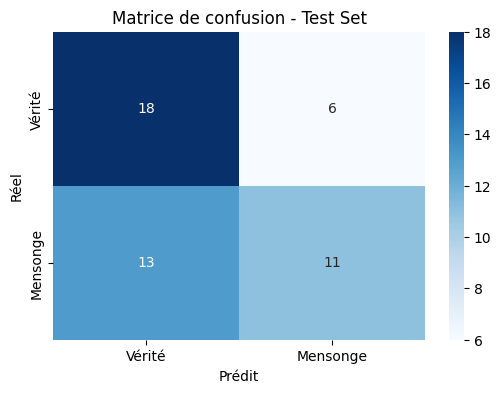

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Calcul de la matrice
cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Vérité", "Mensonge"],
            yticklabels=["Vérité", "Mensonge"])
plt.xlabel("Prédit")
plt.ylabel("Réel")
plt.title("Matrice de confusion - Test Set")
plt.show()


# vraie fusion attentionnelle texte + audio sans tout casser dans ton pipeline actuel 💪

L’idée :

on garde DistilBERT pour le texte,

on garde les embeddings Wav2Vec2 (768D) pour l’audio,

mais au lieu de juste concaténer [texte ; audio],
👉 on apprend un gate (attention scalaire) qui décide, pour chaque exemple, quelle modalité peser le plus.

# 🧠 1. Principe de l’architecture “gated”

Pour chaque exemple :

Texte → DistilBERT → CLS (768) → projection → text_h (256)

Audio → Wav2Vec2 → embedding (768) → projection → audio_h (256)

On concatène : fusion_in = [text_h ; audio_h] → (512)

On passe dans une couche linéaire + sigmoïde → gate ∈ (0,1)

On fait la fusion :


fused=gate\*text_h+(1−gate)\*audio_h

# Nouveau modèle : MultiModalGatedBertWav2Vec

In [ ]:
import torch
import torch.nn as nn
from transformers import AutoModel

class MultiModalGatedBertWav2Vec(nn.Module):
    def __init__(self, text_model_name, audio_dim=768, num_labels=2,
                 class_weights=None, freeze_bert=False):
        super().__init__()

        # Encodeur texte (DistilBERT, BERT, etc.)
        self.text_encoder = AutoModel.from_pretrained(text_model_name)
        hidden_text = self.text_encoder.config.hidden_size  # 768 pour DistilBERT

        # Projections dans un espace commun 256D
        self.text_proj = nn.Linear(hidden_text, 256)
        self.audio_proj = nn.Linear(audio_dim, 256)

        # Couche de "gating" : produit un scalaire dans (0,1) pour chaque exemple
        # entrées : concat([text_h, audio_h]) → (B, 512)
        self.gate_layer = nn.Linear(512, 1)

        # Classifieur sur le vecteur fusionné 256D
        self.classifier = nn.Sequential(
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, num_labels)
        )

        # Option : geler BERT si tu veux
        if freeze_bert:
            for p in self.text_encoder.parameters():
                p.requires_grad = False

        # Loss pondérée si fournie (pour mieux traiter mensonge)
        if class_weights is not None:
            self.loss_fn = nn.CrossEntropyLoss(weight=class_weights)
        else:
            self.loss_fn = nn.CrossEntropyLoss()

    def forward(self, input_ids, attention_mask, audio_feats, labels=None):
        # 1) Encoding texte
        outputs = self.text_encoder(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        # Pour DistilBERT : approx CLS = token[0]
        cls_emb = outputs.last_hidden_state[:, 0, :]  # (B, 768)

        # 2) Projections
        text_h = self.text_proj(cls_emb)           # (B, 256)
        audio_h = self.audio_proj(audio_feats)     # (B, 256)

        # 3) Gating (attention scalaire)
        fusion_in = torch.cat([text_h, audio_h], dim=1)  # (B, 512)
        gate = torch.sigmoid(self.gate_layer(fusion_in)) # (B, 1)

        # broadcast gate sur les 256 dimensions
        fused = gate * text_h + (1 - gate) * audio_h     # (B, 256)

        # 4) Classification
        logits = self.classifier(fused)                  # (B, num_labels)

        loss = None
        if labels is not None:
            loss = self.loss_fn(logits, labels)

        return {"loss": loss, "logits": logits, "gate": gate}


## 3. Initialisation du modèle (avec pondération des classes)

In [ ]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

classes = np.array([0, 1])
cw = compute_class_weight(class_weight="balanced", classes=classes, y=y_train)
class_weights = torch.tensor(cw, dtype=torch.float32).to(device)
print("Class weights:", class_weights)

model = MultiModalGatedBertWav2Vec(
    text_model_name=text_model_name,        # "distilbert-base-uncased"
    audio_dim=X_train_audio_emb.shape[1],   # normalement 768
    num_labels=2,
    class_weights=class_weights,
    freeze_bert=False
).to(device)


Class weights: tensor([1.0045, 0.9955], device='cuda:0')


## 4. Bonus : analyser l’“attention” texte vs audio

Comme forward retourne aussi gate, on peut regarder ce que le modèle fait en moyenne :

In [ ]:
def inspect_gate(loader, n_batches=5):
    model.eval()
    all_gates = []

    with torch.no_grad():
        for i, batch in enumerate(loader):
            if i >= n_batches:
                break
            batch = {k: v.to(device) for k,v in batch.items()}
            outputs = model(
                input_ids=batch["input_ids"],
                attention_mask=batch["attention_mask"],
                audio_feats=batch["audio_feats"],
                labels=batch["labels"]
            )
            gate = outputs["gate"].cpu().numpy()  # (B,1)
            all_gates.extend(gate.flatten())

    all_gates = np.array(all_gates)
    print("Gate moyen :", all_gates.mean())
    print("Gate min/max :", all_gates.min(), all_gates.max())
    print("Interprétation :")
    print(" - proche de 1 → le modèle s'appuie surtout sur le TEXTE")
    print(" - proche de 0 → il s'appuie surtout sur l'AUDIO")

inspect_gate(val_loader, n_batches=10)


Gate moyen : 0.4619012
Gate min/max : 0.45036635 0.48554868
Interprétation :
 - proche de 1 → le modèle s'appuie surtout sur le TEXTE
 - proche de 0 → il s'appuie surtout sur l'AUDIO


In [ ]:
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
num_epochs = 15
patience = 3  # early stopping
best_val_f1 = 0.0
epochs_no_improve = 0
best_state = None

def evaluate(loader):
    model.eval()
    all_preds, all_labels = [], []
    total_loss = 0.0

    with torch.no_grad():
        for batch in loader:
            batch = {k: v.to(device) for k,v in batch.items()}
            outputs = model(
                input_ids=batch["input_ids"],
                attention_mask=batch["attention_mask"],
                audio_feats=batch["audio_feats"],
                labels=batch["labels"]
            )
            loss = outputs["loss"]
            logits = outputs["logits"]

            preds = logits.argmax(dim=1).cpu().numpy()
            labels = batch["labels"].cpu().numpy()

            all_preds.extend(preds)
            all_labels.extend(labels)
            total_loss += loss.item()

    avg_loss = total_loss / len(loader)
    acc = accuracy_score(all_labels, all_preds)
    precision, recall, f1, _ = precision_recall_fscore_support(
        all_labels, all_preds, average=None, labels=[0,1]
    )
    # f1_mensonge = index 1
    return avg_loss, acc, precision, recall, f1

for epoch in range(num_epochs):
    model.train()
    total_train_loss = 0.0

    for batch in train_loader:
        batch = {k: v.to(device) for k,v in batch.items()}

        optimizer.zero_grad()
        outputs = model(
            input_ids=batch["input_ids"],
            attention_mask=batch["attention_mask"],
            audio_feats=batch["audio_feats"],
            labels=batch["labels"]
        )
        loss = outputs["loss"]
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()

    train_loss = total_train_loss / len(train_loader)
    val_loss, val_acc, val_prec, val_rec, val_f1 = evaluate(val_loader)
    f1_mensonge = val_f1[1]

    print(f"Epoch {epoch+1}/{num_epochs} | "
          f"Train loss: {train_loss:.3f} | Val loss: {val_loss:.3f} | "
          f"Val Acc: {val_acc:.3f} | F1 mensonge: {f1_mensonge:.3f}")

    # Early stopping sur F1 mensonge
    if f1_mensonge > best_val_f1:
        best_val_f1 = f1_mensonge
        best_state = model.state_dict()
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print("Early stopping déclenché.")
            break

# Charger le meilleur modèle
if best_state is not None:
    model.load_state_dict(best_state)
    print("Meilleur modèle chargé (F1 mensonge val =", best_val_f1, ")")


Epoch 1/15 | Train loss: 0.123 | Val loss: 1.221 | Val Acc: 0.551 | F1 mensonge: 0.560
Epoch 2/15 | Train loss: 0.076 | Val loss: 1.396 | Val Acc: 0.571 | F1 mensonge: 0.604
Epoch 3/15 | Train loss: 0.055 | Val loss: 1.392 | Val Acc: 0.531 | F1 mensonge: 0.582
Epoch 4/15 | Train loss: 0.034 | Val loss: 1.847 | Val Acc: 0.510 | F1 mensonge: 0.455
Epoch 5/15 | Train loss: 0.051 | Val loss: 1.807 | Val Acc: 0.510 | F1 mensonge: 0.667
Epoch 6/15 | Train loss: 0.053 | Val loss: 1.648 | Val Acc: 0.510 | F1 mensonge: 0.600
Epoch 7/15 | Train loss: 0.026 | Val loss: 2.002 | Val Acc: 0.510 | F1 mensonge: 0.520
Epoch 8/15 | Train loss: 0.015 | Val loss: 1.737 | Val Acc: 0.531 | F1 mensonge: 0.610
Early stopping déclenché.
Meilleur modèle chargé (F1 mensonge val = 0.6666666666666666 )


In [ ]:
from sklearn.metrics import classification_report

test_loss, test_acc, test_prec, test_rec, test_f1 = evaluate(test_loader)
all_preds, all_labels = [], []

model.eval()
with torch.no_grad():
    for batch in test_loader:
        batch = {k: v.to(device) for k,v in batch.items()}
        outputs = model(
            input_ids=batch["input_ids"],
            attention_mask=batch["attention_mask"],
            audio_feats=batch["audio_feats"],
            labels=batch["labels"]
        )
        logits = outputs["logits"]
        preds = logits.argmax(dim=1).cpu().numpy()
        labels = batch["labels"].cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(labels)

print("=== Résultats test ===")
print("Loss :", test_loss)
print("Accuracy :", test_acc)
print(classification_report(all_labels, all_preds, target_names=["Vérité", "Mensonge"]))


=== Résultats test ===
Loss : 1.387749542792638
Accuracy : 0.6875
              precision    recall  f1-score   support

      Vérité       0.70      0.67      0.68        24
    Mensonge       0.68      0.71      0.69        24

    accuracy                           0.69        48
   macro avg       0.69      0.69      0.69        48
weighted avg       0.69      0.69      0.69        48



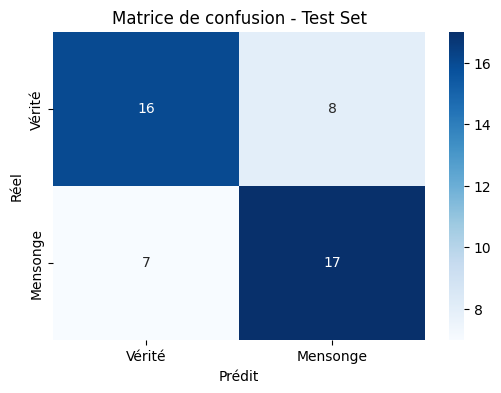

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Calcul de la matrice
cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Vérité", "Mensonge"],
            yticklabels=["Vérité", "Mensonge"])
plt.xlabel("Prédit")
plt.ylabel("Réel")
plt.title("Matrice de confusion - Test Set")
plt.show()


# TRAITEMENT MULTIMODAL AVEC (TEXT AUDIO ET VIDEO)

## Extraire des embeddings vidéo par séquence (un vecteur par vidéo MU3D)

Construire un Dataset tri-modal (texte + audio + vidéo)

Définir un modèle tri-modal avec attention/gating entre les 3 modalités

Réutiliser ta boucle d’entraînement / early stopping / ACC@k

## 1️⃣ Extraction d’embeddings vidéo (par vidéo)

Idée simple et faisable sur Colab :

On échantillonne quelques frames par vidéo (ex. 8)

On passe chaque frame dans un ResNet18 pré-entraîné ImageNet

On moyenne les features des frames → un vecteur de 512 dimensions par vidéo

In [ ]:
!pip install opencv-python --quiet

import cv2
import numpy as np
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as T
from tqdm import tqdm
import os


## b) Charger le modèle ResNet18 sans la dernière couche

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device :", device)

resnet = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
resnet.fc = nn.Identity()  # on enlève la couche de classification → features 512D
resnet = resnet.to(device)
resnet.eval()

# Transforms pour les frames
transform = T.Compose([
    T.ToPILImage(),
    T.Resize((224, 224)),
    T.ToTensor(),
    T.Normalize(
        mean=[0.485, 0.456, 0.406],  # ImageNet
        std=[0.229, 0.224, 0.225]
    )
])


Device : cuda
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 160MB/s]


## c) Fonction pour extraire un embedding vidéo

In [ ]:
def extract_video_embedding(video_path, num_frames=8):
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        return None

    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    if frame_count <= 0:
        cap.release()
        return None

    # indices de frames à échantillonner
    idxs = np.linspace(0, frame_count - 1, num_frames, dtype=int)
    frames = []

    for idx in idxs:
        cap.set(cv2.CAP_PROP_POS_FRAMES, int(idx))
        ret, frame = cap.read()
        if not ret:
            continue
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frame_t = transform(frame)
        frames.append(frame_t)

    cap.release()

    if len(frames) == 0:
        return None

    frames_t = torch.stack(frames).to(device)  # (F, 3, 224, 224)

    with torch.no_grad():
        feats = resnet(frames_t)   # (F, 512)
        emb = feats.mean(dim=0)    # (512,)

    return emb.cpu().numpy()


## Boucle sur toutes les vidéos MU3D

In [ ]:
video_emb_list = []

for path in tqdm(df_vid["video_path"]):
    if isinstance(path, str) and os.path.exists(path):
        emb = extract_video_embedding(path)
        if emb is None:
            emb = np.zeros(512, dtype=np.float32)
    else:
        emb = np.zeros(512, dtype=np.float32)
    video_emb_list.append(emb)

video_emb = np.stack(video_emb_list).astype(np.float32)  # shape (N, 512)
video_emb.shape


100%|██████████| 320/320 [11:30<00:00,  2.16s/it]


(320, 512)

## Préparer les splits tri-modaux (texte + audio + vidéo)

In [ ]:
texts  = df_vid["Transcription"].values
labels = df_vid["label"].values
audio_features = build_audio_embeddings(df_vid["audio_path"].values)  # (N, 768) de Wav2Vec2
video_features = video_emb    # (N, 512)

100%|██████████| 320/320 [01:05<00:00,  4.88it/s]


In [ ]:
from sklearn.model_selection import train_test_split

X_temp_text, X_test_text, y_temp, y_test, X_temp_audio, X_test_audio, X_temp_video, X_test_video = train_test_split(
    texts, labels, audio_features, video_features,
    test_size=0.15, random_state=42, stratify=labels
)

X_train_text, X_val_text, y_train, y_val, X_train_audio, X_val_audio, X_train_video, X_val_video = train_test_split(
    X_temp_text, y_temp, X_temp_audio, X_temp_video,
    test_size=0.1765, random_state=42, stratify=y_temp
)

print(len(X_train_text), len(X_val_text), len(X_test_text))


223 49 48


## Nouveau Dataset : Texte + Audio + Vidéo

On étend ton TextAudioDataset → TextAudioVideoDataset :

In [ ]:
from torch.utils.data import Dataset
from transformers import AutoTokenizer

text_model_name = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(text_model_name)

class TextAudioVideoDataset(Dataset):
    def __init__(self, texts, audio_embs, video_embs, labels, tokenizer, max_len=128):
        self.texts = list(texts)
        self.audio_embs = audio_embs
        self.video_embs = video_embs
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        audio_vec = self.audio_embs[idx]
        video_vec = self.video_embs[idx]
        label = self.labels[idx]

        enc = self.tokenizer(
            text,
            padding="max_length",
            truncation=True,
            max_length=self.max_len,
            return_tensors="pt"
        )

        return {
            "input_ids": enc["input_ids"].squeeze(0),
            "attention_mask": enc["attention_mask"].squeeze(0),
            "audio_feats": torch.tensor(audio_vec, dtype=torch.float32),
            "video_feats": torch.tensor(video_vec, dtype=torch.float32),
            "labels": torch.tensor(label, dtype=torch.long),
        }

train_dataset = TextAudioVideoDataset(X_train_text, X_train_audio, X_train_video, y_train, tokenizer)
val_dataset   = TextAudioVideoDataset(X_val_text,   X_val_audio,   X_val_video,   y_val,   tokenizer)
test_dataset  = TextAudioVideoDataset(X_test_text,  X_test_audio,  X_test_video,  y_test,  tokenizer)


## Loaders :

In [ ]:
from torch.utils.data import DataLoader

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader   = DataLoader(val_dataset,   batch_size=8, shuffle=False)
test_loader  = DataLoader(test_dataset,  batch_size=8, shuffle=False)


## Nouveau modèle : Texte + Audio + Vidéo avec gating tri-modal

On va généraliser ton modèle à 3 modalités avec un gating softmax :

On projette texte/audio/vidéo dans un espace commun hidden_dim

On calcule 3 poids (w_text, w_audio, w_video) via softmax

Vecteur fusion = w_t * text_h + w_a * audio_h + w_v * video_h

In [ ]:
class MultiModalTriGated(nn.Module):
    def __init__(
        self,
        text_model_name,
        audio_dim=768,
        video_dim=512,
        num_labels=2,
        class_weights=None,
        freeze_bert=False,
        hidden_dim=256,
        classifier_hidden=128,
        dropout=0.3
    ):
        super().__init__()

        self.text_encoder = AutoModel.from_pretrained(text_model_name)
        hidden_text = self.text_encoder.config.hidden_size  # 768

        # projections
        self.text_proj  = nn.Linear(hidden_text, hidden_dim)
        self.audio_proj = nn.Linear(audio_dim, hidden_dim)
        self.video_proj = nn.Linear(video_dim, hidden_dim)

        # gating tri-modal : entrée concat([t,a,v]) → 3 poids
        self.gate_layer = nn.Linear(3 * hidden_dim, 3)

        self.classifier = nn.Sequential(
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, classifier_hidden),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(classifier_hidden, num_labels)
        )

        if freeze_bert:
            for p in self.text_encoder.parameters():
                p.requires_grad = False

        if class_weights is not None:
            self.loss_fn = nn.CrossEntropyLoss(weight=class_weights)
        else:
            self.loss_fn = nn.CrossEntropyLoss()

    def forward(self, input_ids, attention_mask, audio_feats, video_feats, labels=None):
        # Texte
        outputs = self.text_encoder(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        cls_emb = outputs.last_hidden_state[:, 0, :]  # (B, 768)

        text_h  = self.text_proj(cls_emb)           # (B, H)
        audio_h = self.audio_proj(audio_feats)      # (B, H)
        video_h = self.video_proj(video_feats)      # (B, H)

        # Gating
        fusion_in = torch.cat([text_h, audio_h, video_h], dim=1)  # (B, 3H)
        gate_logits = self.gate_layer(fusion_in)                  # (B, 3)
        gate_weights = torch.softmax(gate_logits, dim=1)          # (B, 3)

        w_text  = gate_weights[:, 0].unsqueeze(1)  # (B,1)
        w_audio = gate_weights[:, 1].unsqueeze(1)
        w_video = gate_weights[:, 2].unsqueeze(1)

        fused = w_text * text_h + w_audio * audio_h + w_video * video_h  # (B, H)

        logits = self.classifier(fused)

        loss = None
        if labels is not None:
            loss = self.loss_fn(logits, labels)

        return {"loss": loss, "logits": logits, "gate": gate_weights}


In [ ]:
from torch.utils.data import DataLoader
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Loaders
batch_size = 8

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_dataset,   batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_dataset,  batch_size=batch_size, shuffle=False)

# Poids de classes pour mieux traiter "mensonge"
classes = np.array([0, 1])
class_weights_np = compute_class_weight(
    class_weight="balanced",
    classes=classes,
    y=y_train
)
class_weights = torch.tensor(class_weights_np, dtype=torch.float32).to(device)
print("Class weights :", class_weights)

# Init du modèle tri-modal
text_model_name = "distilbert-base-uncased"
audio_dim = X_train_audio.shape[1]   # ex: 768
video_dim = X_train_video.shape[1]   # ex: 512

model = MultiModalTriGated(
    text_model_name=text_model_name,
    audio_dim=audio_dim,
    video_dim=video_dim,
    num_labels=2,
    class_weights=class_weights,
    freeze_bert=False,       # ou True si tu veux geler BERT
    hidden_dim=256,
    classifier_hidden=128,
    dropout=0.3
).to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=3e-5)


Class weights : tensor([1.0045, 0.9955], device='cuda:0')


In [ ]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def evaluate(model, loader, device):
    model.eval()
    all_preds, all_labels = [], []
    all_logits = []
    total_loss = 0.0

    with torch.no_grad():
        for batch in loader:
            batch = {k: v.to(device) for k, v in batch.items()}

            outputs = model(
                input_ids=batch["input_ids"],
                attention_mask=batch["attention_mask"],
                audio_feats=batch["audio_feats"],
                video_feats=batch["video_feats"],   # ← important
                labels=batch["labels"]
            )
            loss = outputs["loss"]
            logits = outputs["logits"]

            preds = logits.argmax(dim=1).cpu().numpy()
            labels = batch["labels"].cpu().numpy()

            all_preds.extend(preds)
            all_labels.extend(labels)
            all_logits.append(logits.cpu().numpy())
            total_loss += loss.item()

    all_logits = np.concatenate(all_logits, axis=0)
    avg_loss = total_loss / len(loader)
    acc = accuracy_score(all_labels, all_preds)
    precision, recall, f1, _ = precision_recall_fscore_support(
        all_labels, all_preds, average=None, labels=[0, 1]
    )
    return avg_loss, acc, precision, recall, f1, all_logits, np.array(all_labels)


In [ ]:
num_epochs = 15
patience = 3 # nombre d'époques sans amélioration avant arrêt
best_val_f1_mensonge = 0.0
best_state = None
epochs_no_improve = 0

for epoch in range(num_epochs):
    model.train()
    total_train_loss = 0.0

    for batch in train_loader:
        batch = {k: v.to(device) for k, v in batch.items()}

        optimizer.zero_grad()
        outputs = model(
            input_ids=batch["input_ids"],
            attention_mask=batch["attention_mask"],
            audio_feats=batch["audio_feats"],
            video_feats=batch["video_feats"],   # ← tri-modal
            labels=batch["labels"]
        )
        loss = outputs["loss"]
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()

    train_loss = total_train_loss / len(train_loader)
    val_loss, val_acc, val_prec, val_rec, val_f1, _, _ = evaluate(model, val_loader, device)
    f1_mensonge = val_f1[1]  # index 1 = classe "mensonge"

    print(f"Epoch {epoch+1}/{num_epochs} | "
          f"Train loss: {train_loss:.3f} | Val loss: {val_loss:.3f} | "
          f"Val Acc: {val_acc:.3f} | F1 mensonge: {f1_mensonge:.3f}")

    # Early stopping sur F1(mensonge)
    if f1_mensonge > best_val_f1_mensonge:
        best_val_f1_mensonge = f1_mensonge
        best_state = model.state_dict()
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print("Early stopping déclenché.")
            break

# Charger le meilleur modèle (meilleure F1 mensonge val)
if best_state is not None:
    model.load_state_dict(best_state)
    print("Meilleur modèle restauré (F1 mensonge val =", best_val_f1_mensonge, ")")


Epoch 1/15 | Train loss: 0.012 | Val loss: 2.316 | Val Acc: 0.510 | F1 mensonge: 0.613
Epoch 2/15 | Train loss: 0.013 | Val loss: 2.144 | Val Acc: 0.551 | F1 mensonge: 0.312
Epoch 3/15 | Train loss: 0.014 | Val loss: 1.919 | Val Acc: 0.633 | F1 mensonge: 0.625
Epoch 4/15 | Train loss: 0.021 | Val loss: 1.894 | Val Acc: 0.592 | F1 mensonge: 0.500
Epoch 5/15 | Train loss: 0.016 | Val loss: 2.207 | Val Acc: 0.551 | F1 mensonge: 0.621
Epoch 6/15 | Train loss: 0.006 | Val loss: 1.768 | Val Acc: 0.612 | F1 mensonge: 0.578
Early stopping déclenché.
Meilleur modèle restauré (F1 mensonge val = 0.625 )


In [ ]:
def topk_accuracy(y_true, y_proba, k, positive_class=1):
    """
    y_true  : array (N,)
    y_proba : array (N, 2) = proba [classe0, classe1]
    k       : nombre de cas les plus suspects
    """
    prob_pos = y_proba[:, positive_class]
    idx_sorted = np.argsort(prob_pos)[::-1]      # tri décroissant
    topk_idx = idx_sorted[:k]
    topk_true = y_true[topk_idx]
    return (topk_true == positive_class).sum() / k


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import torch.nn.functional as F
import seaborn as sns
import matplotlib.pyplot as plt

def evaluate_on_test(model, test_dataset, device="cuda"):
    test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

    test_loss, test_acc, prec, rec, f1, logits, y_true = evaluate(model, test_loader, device)
    y_proba = F.softmax(torch.tensor(logits), dim=1).numpy()
    y_pred = np.argmax(y_proba, axis=1)

    print("\n=== Résultats test ===")
    print("Loss :", test_loss)
    print("Accuracy :", test_acc)
    print(classification_report(y_true, y_pred,
                                target_names=["Vérité", "Mensonge"]))

    # Matrice de confusion
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(4,4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=["Vérité", "Mensonge"],
                yticklabels=["Vérité", "Mensonge"])
    plt.xlabel("Prédit")
    plt.ylabel("Réel")
    plt.title("Matrice de confusion - Test Set")
    plt.show()

    # ACC@k (classe positive = mensonge = 1)
    acc2 = topk_accuracy(y_true, y_proba, 2, positive_class=1)
    acc5 = topk_accuracy(y_true, y_proba, 5, positive_class=1)
    acc7 = topk_accuracy(y_true, y_proba, 7, positive_class=1)
    print(f"ACC@2 = {acc2:.3f}")
    print(f"ACC@5 = {acc5:.3f}")
    print(f"ACC@7 = {acc7:.3f}")

    return test_loss, test_acc, prec, rec, f1, acc2, acc5, acc7



=== Résultats test ===
Loss : 1.6725337704022725
Accuracy : 0.6666666666666666
              precision    recall  f1-score   support

      Vérité       0.62      0.83      0.71        24
    Mensonge       0.75      0.50      0.60        24

    accuracy                           0.67        48
   macro avg       0.69      0.67      0.66        48
weighted avg       0.69      0.67      0.66        48



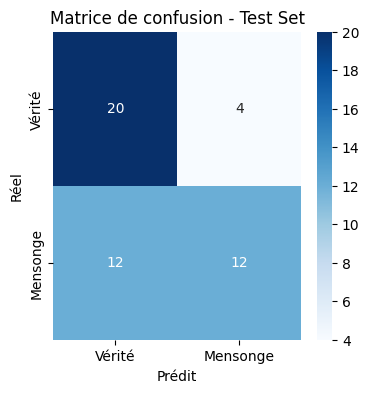

ACC@2 = 0.500
ACC@5 = 0.800
ACC@7 = 0.857


In [ ]:
test_loss, test_acc, prec, rec, f1, acc2, acc5, acc7 = evaluate_on_test(
    model, test_dataset, device=device
)


In [ ]:
def inspect_gates(model, loader, device, n_batches=5):
    model.eval()
    all_gates = []

    with torch.no_grad():
        for i, batch in enumerate(loader):
            if i >= n_batches:
                break
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(
                input_ids=batch["input_ids"],
                attention_mask=batch["attention_mask"],
                audio_feats=batch["audio_feats"],
                video_feats=batch["video_feats"],
                labels=batch["labels"]
            )
            gate = outputs["gate"].cpu().numpy()  # (B, 3)
            all_gates.append(gate)

    all_gates = np.concatenate(all_gates, axis=0)
    mean_gate = all_gates.mean(axis=0)
    print("Gate moyen (texte, audio, vidéo) :", mean_gate)
    print("Interprétation : plus la valeur est grande, plus la modalité est utilisée.")

inspect_gates(model, val_loader, device, n_batches=10)


Gate moyen (texte, audio, vidéo) : [0.997734   0.00117342 0.00109274]
Interprétation : plus la valeur est grande, plus la modalité est utilisée.


In [ ]:
texts         = df_vid["Transcription"].values          # (N,)
labels        = df_vid["label"].values                  # (N,), 0 = vérité, 1 = mensonge
audio_emb_all = audio_features       # (N, audio_dim) ex: Wav2Vec2 (768)
video_emb_all = video_features         # (N, video_dim) ex: ResNet (512)


In [ ]:
from transformers import AutoTokenizer
text_model_name = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(text_model_name)

import torch, torch.nn as nn
import numpy as np
from sklearn.model_selection import train_test_split


In [ ]:
X_temp_text, X_test_text, y_temp, y_test, \
X_temp_audio, X_test_audio, \
X_temp_video, X_test_video = train_test_split(
    texts, labels, audio_emb_all, video_emb_all,
    test_size=0.15, random_state=42, stratify=labels
)

X_train_text, X_val_text, y_train, y_val, \
X_train_audio, X_val_audio, \
X_train_video, X_val_video = train_test_split(
    X_temp_text, y_temp, X_temp_audio, X_temp_video,
    test_size=0.1765, random_state=42, stratify=y_temp
)

print(len(X_train_text), len(X_val_text), len(X_test_text))


223 49 48


In [ ]:
from torch.utils.data import Dataset

class TextAudioDataset(Dataset):
    def __init__(self, texts, audio_embs, labels, tokenizer, max_len=128):
        self.texts = list(texts)
        self.audio_embs = audio_embs
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        audio_vec = self.audio_embs[idx]
        label = self.labels[idx]

        enc = self.tokenizer(
            text,
            padding="max_length",
            truncation=True,
            max_length=self.max_len,
            return_tensors="pt"
        )

        return {
            "input_ids": enc["input_ids"].squeeze(0),
            "attention_mask": enc["attention_mask"].squeeze(0),
            "other_feats": torch.tensor(audio_vec, dtype=torch.float32),
            "labels": torch.tensor(label, dtype=torch.long),
        }


In [ ]:
class TextVideoDataset(Dataset):
    def __init__(self, texts, video_embs, labels, tokenizer, max_len=128):
        self.texts = list(texts)
        self.video_embs = video_embs
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        video_vec = self.video_embs[idx]
        label = self.labels[idx]

        enc = self.tokenizer(
            text,
            padding="max_length",
            truncation=True,
            max_length=self.max_len,
            return_tensors="pt"
        )

        return {
            "input_ids": enc["input_ids"].squeeze(0),
            "attention_mask": enc["attention_mask"].squeeze(0),
            "other_feats": torch.tensor(video_vec, dtype=torch.float32),
            "labels": torch.tensor(label, dtype=torch.long),
        }


In [ ]:
from transformers import AutoModel

class BimodalGatedTextOther(nn.Module):
    def __init__(
        self,
        text_model_name,
        other_dim,           # audio_dim ou video_dim
        num_labels=2,
        class_weights=None,
        freeze_bert=False,
        hidden_dim=256,
        classifier_hidden=128,
        dropout=0.3
    ):
        super().__init__()

        self.text_encoder = AutoModel.from_pretrained(text_model_name)
        hidden_text = self.text_encoder.config.hidden_size  # 768 pour DistilBERT

        # Projections vers un espace commun
        self.text_proj  = nn.Linear(hidden_text, hidden_dim)
        self.other_proj = nn.Linear(other_dim, hidden_dim)

        # (Optionnel) normalisation pour stabiliser
        self.text_norm  = nn.LayerNorm(hidden_dim)
        self.other_norm = nn.LayerNorm(hidden_dim)

        # Gate : entrée concat([text_h, other_h]) → 2 poids (texte, autre)
        self.gate_layer = nn.Linear(2 * hidden_dim, 2)

        self.classifier = nn.Sequential(
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, classifier_hidden),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(classifier_hidden, num_labels)
        )

        if freeze_bert:
            for p in self.text_encoder.parameters():
                p.requires_grad = False

        if class_weights is not None:
            self.loss_fn = nn.CrossEntropyLoss(weight=class_weights)
        else:
            self.loss_fn = nn.CrossEntropyLoss()

    def forward(self, input_ids, attention_mask, other_feats, labels=None):
        # TEXTE
        outputs = self.text_encoder(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        cls_emb = outputs.last_hidden_state[:, 0, :]  # (B, 768)

        text_h  = self.text_norm(self.text_proj(cls_emb))
        other_h = self.other_norm(self.other_proj(other_feats))

        fusion_in = torch.cat([text_h, other_h], dim=1)  # (B, 2H)
        gate_logits = self.gate_layer(fusion_in)         # (B, 2)
        gate_weights = torch.softmax(gate_logits, dim=1) # (B, 2)

        w_text  = gate_weights[:, 0].unsqueeze(1)
        w_other = gate_weights[:, 1].unsqueeze(1)

        fused = w_text * text_h + w_other * other_h      # (B, H)

        logits = self.classifier(fused)

        loss = None
        if labels is not None:
            loss = self.loss_fn(logits, labels)

        return {"loss": loss, "logits": logits, "gate": gate_weights}


In [ ]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def evaluate(model, loader, device):
    model.eval()
    all_preds, all_labels = [], []
    all_logits = []
    total_loss = 0.0

    with torch.no_grad():
        for batch in loader:
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(
                input_ids=batch["input_ids"],
                attention_mask=batch["attention_mask"],
                other_feats=batch["other_feats"],
                labels=batch["labels"]
            )
            loss = outputs["loss"]
            logits = outputs["logits"]

            preds = logits.argmax(dim=1).cpu().numpy()
            labels = batch["labels"].cpu().numpy()

            all_preds.extend(preds)
            all_labels.extend(labels)
            all_logits.append(logits.cpu().numpy())
            total_loss += loss.item()

    all_logits = np.concatenate(all_logits, axis=0)
    avg_loss = total_loss / len(loader)
    acc = accuracy_score(all_labels, all_preds)
    precision, recall, f1, _ = precision_recall_fscore_support(
        all_labels, all_preds, average=None, labels=[0, 1]
    )
    return avg_loss, acc, precision, recall, f1, all_logits, np.array(all_labels)


In [ ]:
from sklearn.utils.class_weight import compute_class_weight

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device :", device)

# poids de classes
classes = np.array([0, 1])
class_weights_np = compute_class_weight(
    class_weight="balanced",
    classes=classes,
    y=y_train
)
class_weights = torch.tensor(class_weights_np, dtype=torch.float32).to(device)
print("Class weights :", class_weights)

def train_bimodal_model(train_dataset, val_dataset, other_dim, mode_name="audio"):
    from torch.utils.data import DataLoader

    batch_size = 8
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader   = DataLoader(val_dataset,   batch_size=batch_size, shuffle=False)

    model = BimodalGatedTextOther(
        text_model_name=text_model_name,
        other_dim=other_dim,
        num_labels=2,
        class_weights=class_weights,
        freeze_bert=False,
        hidden_dim=256,
        classifier_hidden=128,
        dropout=0.3
    ).to(device)

    optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)

    num_epochs = 10
    patience = 3
    best_f1_mensonge = 0.0
    best_state = None
    epochs_no_improve = 0

    for epoch in range(num_epochs):
        model.train()
        total_train_loss = 0.0

        for batch in train_loader:
            batch = {k: v.to(device) for k, v in batch.items()}
            optimizer.zero_grad()

            outputs = model(
                input_ids=batch["input_ids"],
                attention_mask=batch["attention_mask"],
                other_feats=batch["other_feats"],
                labels=batch["labels"]
            )
            loss = outputs["loss"]
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()

        train_loss = total_train_loss / len(train_loader)
        val_loss, val_acc, val_prec, val_rec, val_f1, _, _ = evaluate(model, val_loader, device)
        f1_mensonge = val_f1[1]

        print(f"[{mode_name}] Epoch {epoch+1}/{num_epochs} | "
              f"Train: {train_loss:.3f} | Val: {val_loss:.3f} | "
              f"Val Acc: {val_acc:.3f} | F1 mensonge: {f1_mensonge:.3f}")

        if f1_mensonge > best_f1_mensonge:
            best_f1_mensonge = f1_mensonge
            best_state = model.state_dict()
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print(f"[{mode_name}] Early stopping déclenché.")
                break

    if best_state is not None:
        model.load_state_dict(best_state)
        print(f"[{mode_name}] Meilleur modèle restauré (F1 mensonge val = {best_f1_mensonge:.3f})")

    return model


Device : cuda
Class weights : tensor([1.0045, 0.9955], device='cuda:0')


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import torch.nn.functional as F

def topk_accuracy(y_true, y_proba, k, positive_class=1):
    prob_pos = y_proba[:, positive_class]
    idx_sorted = np.argsort(prob_pos)[::-1]
    topk_idx = idx_sorted[:k]
    topk_true = y_true[topk_idx]
    return (topk_true == positive_class).sum() / k

def evaluate_on_test_bimodal(model, test_dataset, mode_name="audio"):
    from torch.utils.data import DataLoader
    test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

    test_loss, test_acc, prec, rec, f1, logits, y_true = evaluate(model, test_loader, device)
    y_proba = F.softmax(torch.tensor(logits), dim=1).numpy()
    y_pred = np.argmax(y_proba, axis=1)

    print(f"\n=== Résultats test [{mode_name}] ===")
    print("Loss :", test_loss)
    print("Accuracy :", test_acc)
    print(classification_report(y_true, y_pred,
                                target_names=["Vérité", "Mensonge"]))

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(4,4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=["Vérité", "Mensonge"],
                yticklabels=["Vérité", "Mensonge"])
    plt.xlabel("Prédit")
    plt.ylabel("Réel")
    plt.title(f"Matrice de confusion - Test [{mode_name}]")
    plt.show()

    acc2 = topk_accuracy(y_true, y_proba, 2, positive_class=1)
    acc5 = topk_accuracy(y_true, y_proba, 5, positive_class=1)
    acc7 = topk_accuracy(y_true, y_proba, 7, positive_class=1)
    print(f"ACC@2 = {acc2:.3f}")
    print(f"ACC@5 = {acc5:.3f}")
    print(f"ACC@7 = {acc7:.3f}")

    return test_loss, test_acc, prec, rec, f1, acc2, acc5, acc7, y_proba, y_true


[Texte+Audio] Epoch 1/10 | Train: 0.702 | Val: 0.700 | Val Acc: 0.510 | F1 mensonge: 0.077
[Texte+Audio] Epoch 2/10 | Train: 0.684 | Val: 0.699 | Val Acc: 0.490 | F1 mensonge: 0.419
[Texte+Audio] Epoch 3/10 | Train: 0.654 | Val: 0.698 | Val Acc: 0.531 | F1 mensonge: 0.676
[Texte+Audio] Epoch 4/10 | Train: 0.638 | Val: 0.685 | Val Acc: 0.612 | F1 mensonge: 0.642
[Texte+Audio] Epoch 5/10 | Train: 0.495 | Val: 0.861 | Val Acc: 0.531 | F1 mensonge: 0.646
[Texte+Audio] Epoch 6/10 | Train: 0.300 | Val: 0.896 | Val Acc: 0.571 | F1 mensonge: 0.588
[Texte+Audio] Early stopping déclenché.
[Texte+Audio] Meilleur modèle restauré (F1 mensonge val = 0.676)

=== Résultats test [Texte+Audio] ===
Loss : 0.6913037449121475
Accuracy : 0.6666666666666666
              precision    recall  f1-score   support

      Vérité       0.63      0.79      0.70        24
    Mensonge       0.72      0.54      0.62        24

    accuracy                           0.67        48
   macro avg       0.68      0.67    

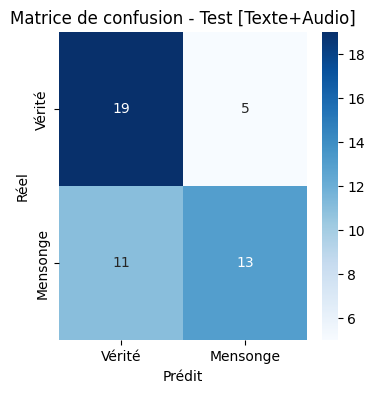

ACC@2 = 1.000
ACC@5 = 0.800
ACC@7 = 0.714


In [ ]:
train_audio_dataset = TextAudioDataset(X_train_text, X_train_audio, y_train, tokenizer)
val_audio_dataset   = TextAudioDataset(X_val_text,   X_val_audio,   y_val,   tokenizer)
test_audio_dataset  = TextAudioDataset(X_test_text,  X_test_audio,  y_test,  tokenizer)

audio_dim = X_train_audio.shape[1]

model_text_audio = train_bimodal_model(
    train_audio_dataset, val_audio_dataset,
    other_dim=audio_dim,
    mode_name="Texte+Audio"
)

res_audio = evaluate_on_test_bimodal(model_text_audio, test_audio_dataset, mode_name="Texte+Audio")


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[Texte+Audio] Epoch 1/10 | Train: 0.714 | Val: 0.704 | Val Acc: 0.510 | F1 mensonge: 0.000


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[Texte+Audio] Epoch 2/10 | Train: 0.695 | Val: 0.704 | Val Acc: 0.510 | F1 mensonge: 0.000
[Texte+Audio] Epoch 3/10 | Train: 0.696 | Val: 0.692 | Val Acc: 0.551 | F1 mensonge: 0.676


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[Texte+Audio] Epoch 4/10 | Train: 0.704 | Val: 0.703 | Val Acc: 0.510 | F1 mensonge: 0.000
[Texte+Audio] Epoch 5/10 | Train: 0.691 | Val: 0.689 | Val Acc: 0.571 | F1 mensonge: 0.588
[Texte+Audio] Epoch 6/10 | Train: 0.680 | Val: 0.666 | Val Acc: 0.633 | F1 mensonge: 0.700
[Texte+Audio] Epoch 7/10 | Train: 0.595 | Val: 0.657 | Val Acc: 0.592 | F1 mensonge: 0.643
[Texte+Audio] Epoch 8/10 | Train: 0.451 | Val: 0.684 | Val Acc: 0.673 | F1 mensonge: 0.692
[Texte+Audio] Epoch 9/10 | Train: 0.311 | Val: 0.852 | Val Acc: 0.571 | F1 mensonge: 0.400
[Texte+Audio] Early stopping déclenché.
[Texte+Audio] Meilleur modèle restauré (F1 mensonge val = 0.700)

=== Résultats test [Texte+Audio] ===
Loss : 0.7038079798221588
Accuracy : 0.6666666666666666
              precision    recall  f1-score   support

      Vérité       0.61      0.96      0.74        24
    Mensonge       0.90      0.38      0.53        24

    accuracy                           0.67        48
   macro avg       0.75      0.67    

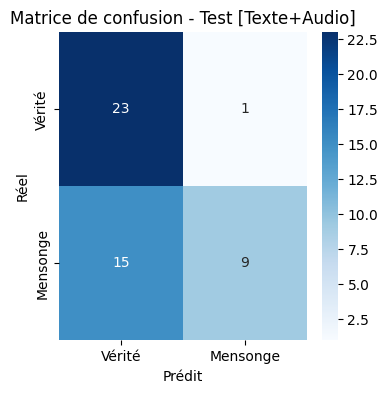

ACC@2 = 0.500
ACC@5 = 0.800
ACC@7 = 0.857


In [ ]:
train_audio_dataset = TextAudioDataset(X_train_text, X_train_audio, y_train, tokenizer)
val_audio_dataset   = TextAudioDataset(X_val_text,   X_val_audio,   y_val,   tokenizer)
test_audio_dataset  = TextAudioDataset(X_test_text,  X_test_audio,  y_test,  tokenizer)

audio_dim = X_train_audio.shape[1]

model_text_audio = train_bimodal_model(
    train_audio_dataset, val_audio_dataset,
    other_dim=audio_dim,
    mode_name="Texte+Audio"
)

res_audio = evaluate_on_test_bimodal(model_text_audio, test_audio_dataset, mode_name="Texte+Audio")


[Texte+Vidéo] Epoch 1/10 | Train: 0.696 | Val: 0.688 | Val Acc: 0.469 | F1 mensonge: 0.618
[Texte+Vidéo] Epoch 2/10 | Train: 0.699 | Val: 0.689 | Val Acc: 0.592 | F1 mensonge: 0.565
[Texte+Vidéo] Epoch 3/10 | Train: 0.679 | Val: 0.690 | Val Acc: 0.551 | F1 mensonge: 0.267
[Texte+Vidéo] Epoch 4/10 | Train: 0.651 | Val: 0.661 | Val Acc: 0.653 | F1 mensonge: 0.691
[Texte+Vidéo] Epoch 5/10 | Train: 0.549 | Val: 0.643 | Val Acc: 0.633 | F1 mensonge: 0.654
[Texte+Vidéo] Epoch 6/10 | Train: 0.376 | Val: 0.822 | Val Acc: 0.673 | F1 mensonge: 0.652
[Texte+Vidéo] Epoch 7/10 | Train: 0.190 | Val: 1.133 | Val Acc: 0.551 | F1 mensonge: 0.312
[Texte+Vidéo] Early stopping déclenché.
[Texte+Vidéo] Meilleur modèle restauré (F1 mensonge val = 0.691)

=== Résultats test [Texte+Vidéo] ===
Loss : 1.0198663274447124
Accuracy : 0.5416666666666666
              precision    recall  f1-score   support

      Vérité       0.53      0.83      0.65        24
    Mensonge       0.60      0.25      0.35        24



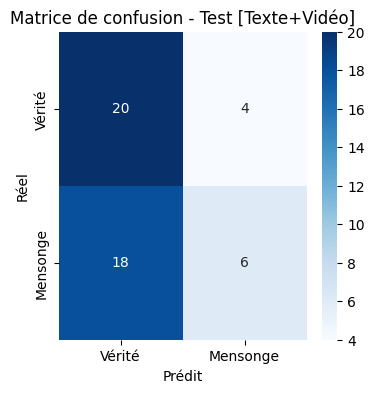

ACC@2 = 0.500
ACC@5 = 0.600
ACC@7 = 0.571


In [ ]:
train_video_dataset = TextVideoDataset(X_train_text, X_train_video, y_train, tokenizer)
val_video_dataset   = TextVideoDataset(X_val_text,   X_val_video,   y_val,   tokenizer)
test_video_dataset  = TextVideoDataset(X_test_text,  X_test_video,  y_test,  tokenizer)

video_dim = X_train_video.shape[1]

model_text_video = train_bimodal_model(
    train_video_dataset, val_video_dataset,
    other_dim=video_dim,
    mode_name="Texte+Vidéo"
)

res_video = evaluate_on_test_bimodal(model_text_video, test_video_dataset, mode_name="Texte+Vidéo")


In [ ]:
torch.save(model_text_audio.state_dict(), "bimodal_text_audio.pt")
